# **Matrix Optimization**

This notebook is a guide to run all large scale (several hours long) experiments for [optimization on unitary networks](https://arxiv.org/abs/1808.00458). These simulations can either be viewed as exploring the optimization space for unitary mesh networks or as a way to simulate (via automatic differentiation rather than gradient measurement) [photonic *in situ* backpropagation](https://www.osapublishing.org/optica/abstract.cfm?uri=optica-5-7-864).

These experiments are primarily meant for getting an understanding of the optimization of photonic architectures but may also prove useful for more general machine learning tasks.

In this notebook, we replicate two core experiments and one appendix experiment in the [paper](https://arxiv.org/abs/1808.00458):
1. **Rectangular versus permuting rectangular meshes**: Nonlocalities in a unitary mesh network where the number of parameters is kept constant can improve the optimization performance.
2. **Rectangular versus redundant rectangular meshes**: A redundant architecture learns a matrix orders of magnitude faster than the rectangular architecture.
3. **Singular value decomposition architectures**: A singular value decomposition architecture can also be learned, though it requires that the gain and loss elements be treated just like nonlinearities in the procedure of the [*in situ* backprop paper](https://www.osapublishing.org/optica/abstract.cfm?uri=optica-5-7-864).

**Note**: due to randomness in target matrix and initialization, there can be a lot of variation between the curves compared to those shown in the paper, but the general trends should match.

In [1]:
# core (tf, numpy, scipy, matplotlib, pbar) imports

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from tqdm import tqdm_notebook as pbar
import pickle

# comment this out if you do not have latex (or associated requirements) installed
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Charter']})
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams.update({'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{amsmath}']})
import warnings
warnings.filterwarnings('ignore')

# neurophox imports
from neurophox.tensorflow import *
from neurophox.ml import LinearMultiModelRunner
from viz import MOResultsVisualizer

## Problem definition

The _training loss_ is defined as follows (note that, as typical in ML contexts, we use right multiply which is different from the left multiply convention used in the theory of our paper):
$$ \|X \hat A - X A \|_F^2,$$
where $X \in \mathbb{C}^{2N \times N}$ is a normalized random synthetic dataset of _batch size_ $2N$ complex vectors, $\hat A = \hat U$ (for unitary matrix optimization) or $\hat A = \hat U \hat \Sigma \hat V$ (for arbitrary linear matrix SVD optimization), $\hat U \in \mathbb{C}^{M \times M}, \hat V \in \mathbb{C}^{N \times N}$ corresponds to predicted unitary matrices, $\hat \Sigma \in \mathbb{C}^{M \times N}$ corresponds to the predicted singular value matrix (parametrized by $\min(M, N)$ `tensorflow` variables) and $A = U$ (unitary) or $\hat A = U \Sigma V$ (SVD) corresponds to the actual complex matrix we are trying to model.

The _test loss_ is defined as the loss where $X = I^{N \times N}$, the $N \times N$ identity matrix. This simplifies to the following:
$$ \|\hat A - A\|_F^2$$

**Important before training**:
1. We have only tested these models on a GPU. The models do runslower on a CPU, but we have not run these models to completion on those devices.
2. We use the `tf.function` utility of Tensorflow 2, which results in some time taken at the beginning to form a static graph for fast implementation of unitary layers on GPU. You will probably need to wait a minute or two before the progress bar starts moving.
3. To visualize tensorboard results, you need to have a `logdir`. Something like `/data/tensorboard/neurophox` should do the trick. Prior to running, it is advised to delete any folders that may be a duplicate for the new run so as to not get confusing tensorboard results or you can timestamp your `experiment_name` to avoid overwriting past experiments.

The class `LinearMultiModelRunner` defines this problem and accepts a list of `layers` and associated `layer_names` along with other visualization options. A class similar to `LinearMultiModelRunner` can also be used to run other neural network models.

## Set up parameters

Set the target unitary matrix and whether to run the optimizations via `RUN_OPTIMIZATION` global variable. This variable is just for this notebook to indicate whether you want to generate or overwrite experiments in the `data/` folder.

In [2]:
N = 128
target = unitary_group.rvs(N)
# Set to True if you haven't run the optimization yet to generate result pickle file.
RUN_OPTIMIZATION = False

## Experiment 1: Add nonlocalities (PRM) ([Figure 6](https://arxiv.org/pdf/1808.00458))

Permuting rectangular meshes (PRM) involves adding nonlocalities to the original rectangular mesh. This experiment takes about 3.5 hours on an NVIDIA GTX1080 GPU. Results vary

**Important before training**:
Please create a data path so that the state of your model can be saved. Something like `/data/tensorboard/neurophox` should do the trick. During the run, all of the names of the models in your `*.jl` file will be the folder names for the saved data. Prior to running, it is advised to delete any folders that may be a duplicate for the new run so as to not get confusing tensorboard results.

### Experiment

In [3]:
if RUN_OPTIMIZATION:
    layers = [
        RM(N), RM(N, bs_error=0.1), RM(N, theta_init_name="random_theta"),
        PRM(N), PRM(N, bs_error=0.1), PRM(N, theta_init_name="random_theta")
    ]

    layer_names = [
        "rm-default", "rm-error", "rm-rand", "prm-default", "prm-error", "prm-rand"
    ]

    mr = LinearMultiModelRunner(experiment_name=f"rm-prm-{N}",
                                layer_names=layer_names,
                                layers=layers,
                                optimizer=tf.keras.optimizers.Adam(lr=0.0025),
                                batch_size=2 * N,
                                iterations_per_epoch=100,
                                iterations_per_tb_update=5,
                                logdir="/data/tensorboard/neurophox/")

    mr.run(200, target, pbar)
    mr.save("data/")

with open('data/rm-prm-128.p', 'rb') as f:
    rm_prm_results = pickle.load(f)

### Plotting (Figure 6a)

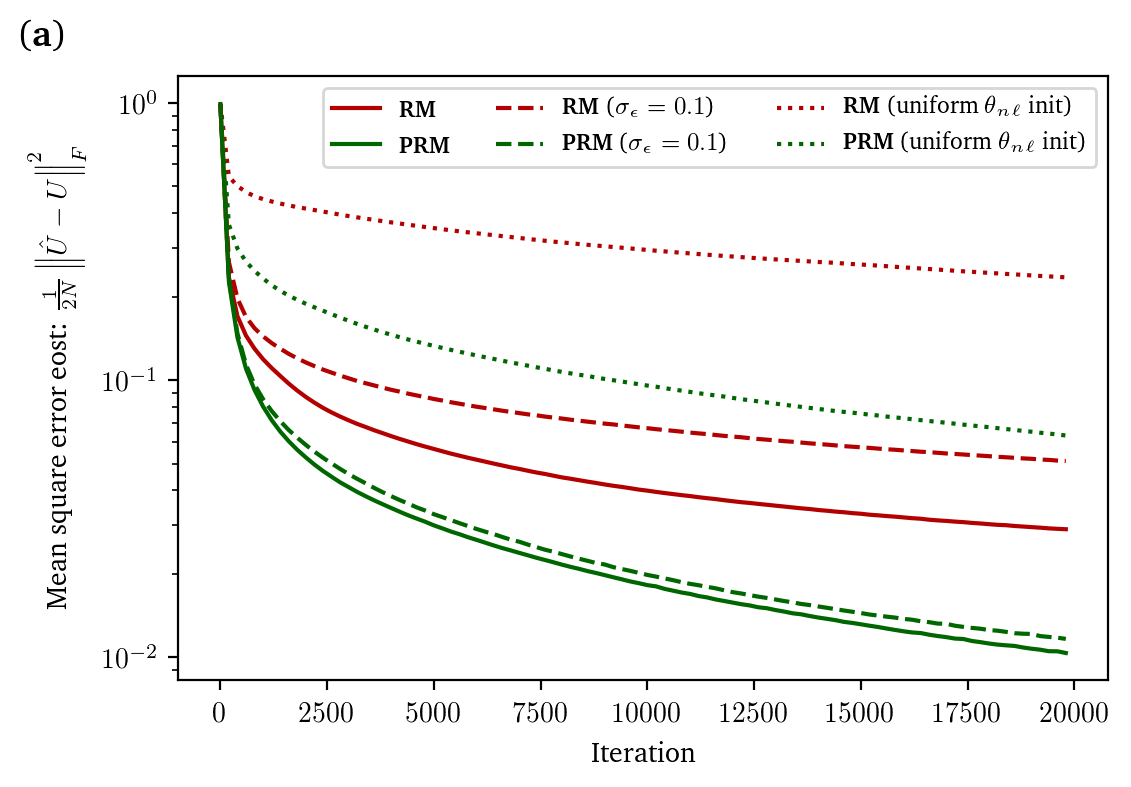

In [6]:
plt.figure(dpi=200)

for name in ["rm-default", "prm-default", "rm-error", "prm-error", "rm-rand", "prm-rand"]:
    if 'rand' in name:
        linestyle = 'dotted'
    elif 'error' in name:
        linestyle = '--'
    else:
        linestyle = '-'
    if 'prm' in name:
        color=[0, 0.4, 0]
    elif 'rm' in name:
        color=[0.7, 0, 0]
    plt.plot(200 * np.arange(100), np.asarray(rm_prm_results['losses'][name][::200]), linestyle=linestyle, color=color)
plt.xlabel('Iteration')
plt.ylabel(r'Mean square error eost: $\frac{1}{2N}\left\lVert\hat U - U\right\rVert_F^2$')
plt.legend([r'\textbf{RM}', r'\textbf{PRM}',
            r'\textbf{RM} ($\sigma_\epsilon = 0.1$)', r'\textbf{PRM} ($\sigma_\epsilon = 0.1$)',
            r'\textbf{RM} (uniform $\theta_{n\ell}$ init)', r'\textbf{PRM} (uniform $\theta_{n\ell}$ init)'],
           ncol=3, fontsize=8.5)
plt.text(-0.17, 1.05, r'(\textbf{a})', transform=plt.axes().transAxes, size=13)
plt.yscale('log')
plt.savefig('data/figures/6a_rm_prm_optimization.pdf', bbox_inches='tight', pad_inches=0.05)

### Plotting (Figure 6b-e)

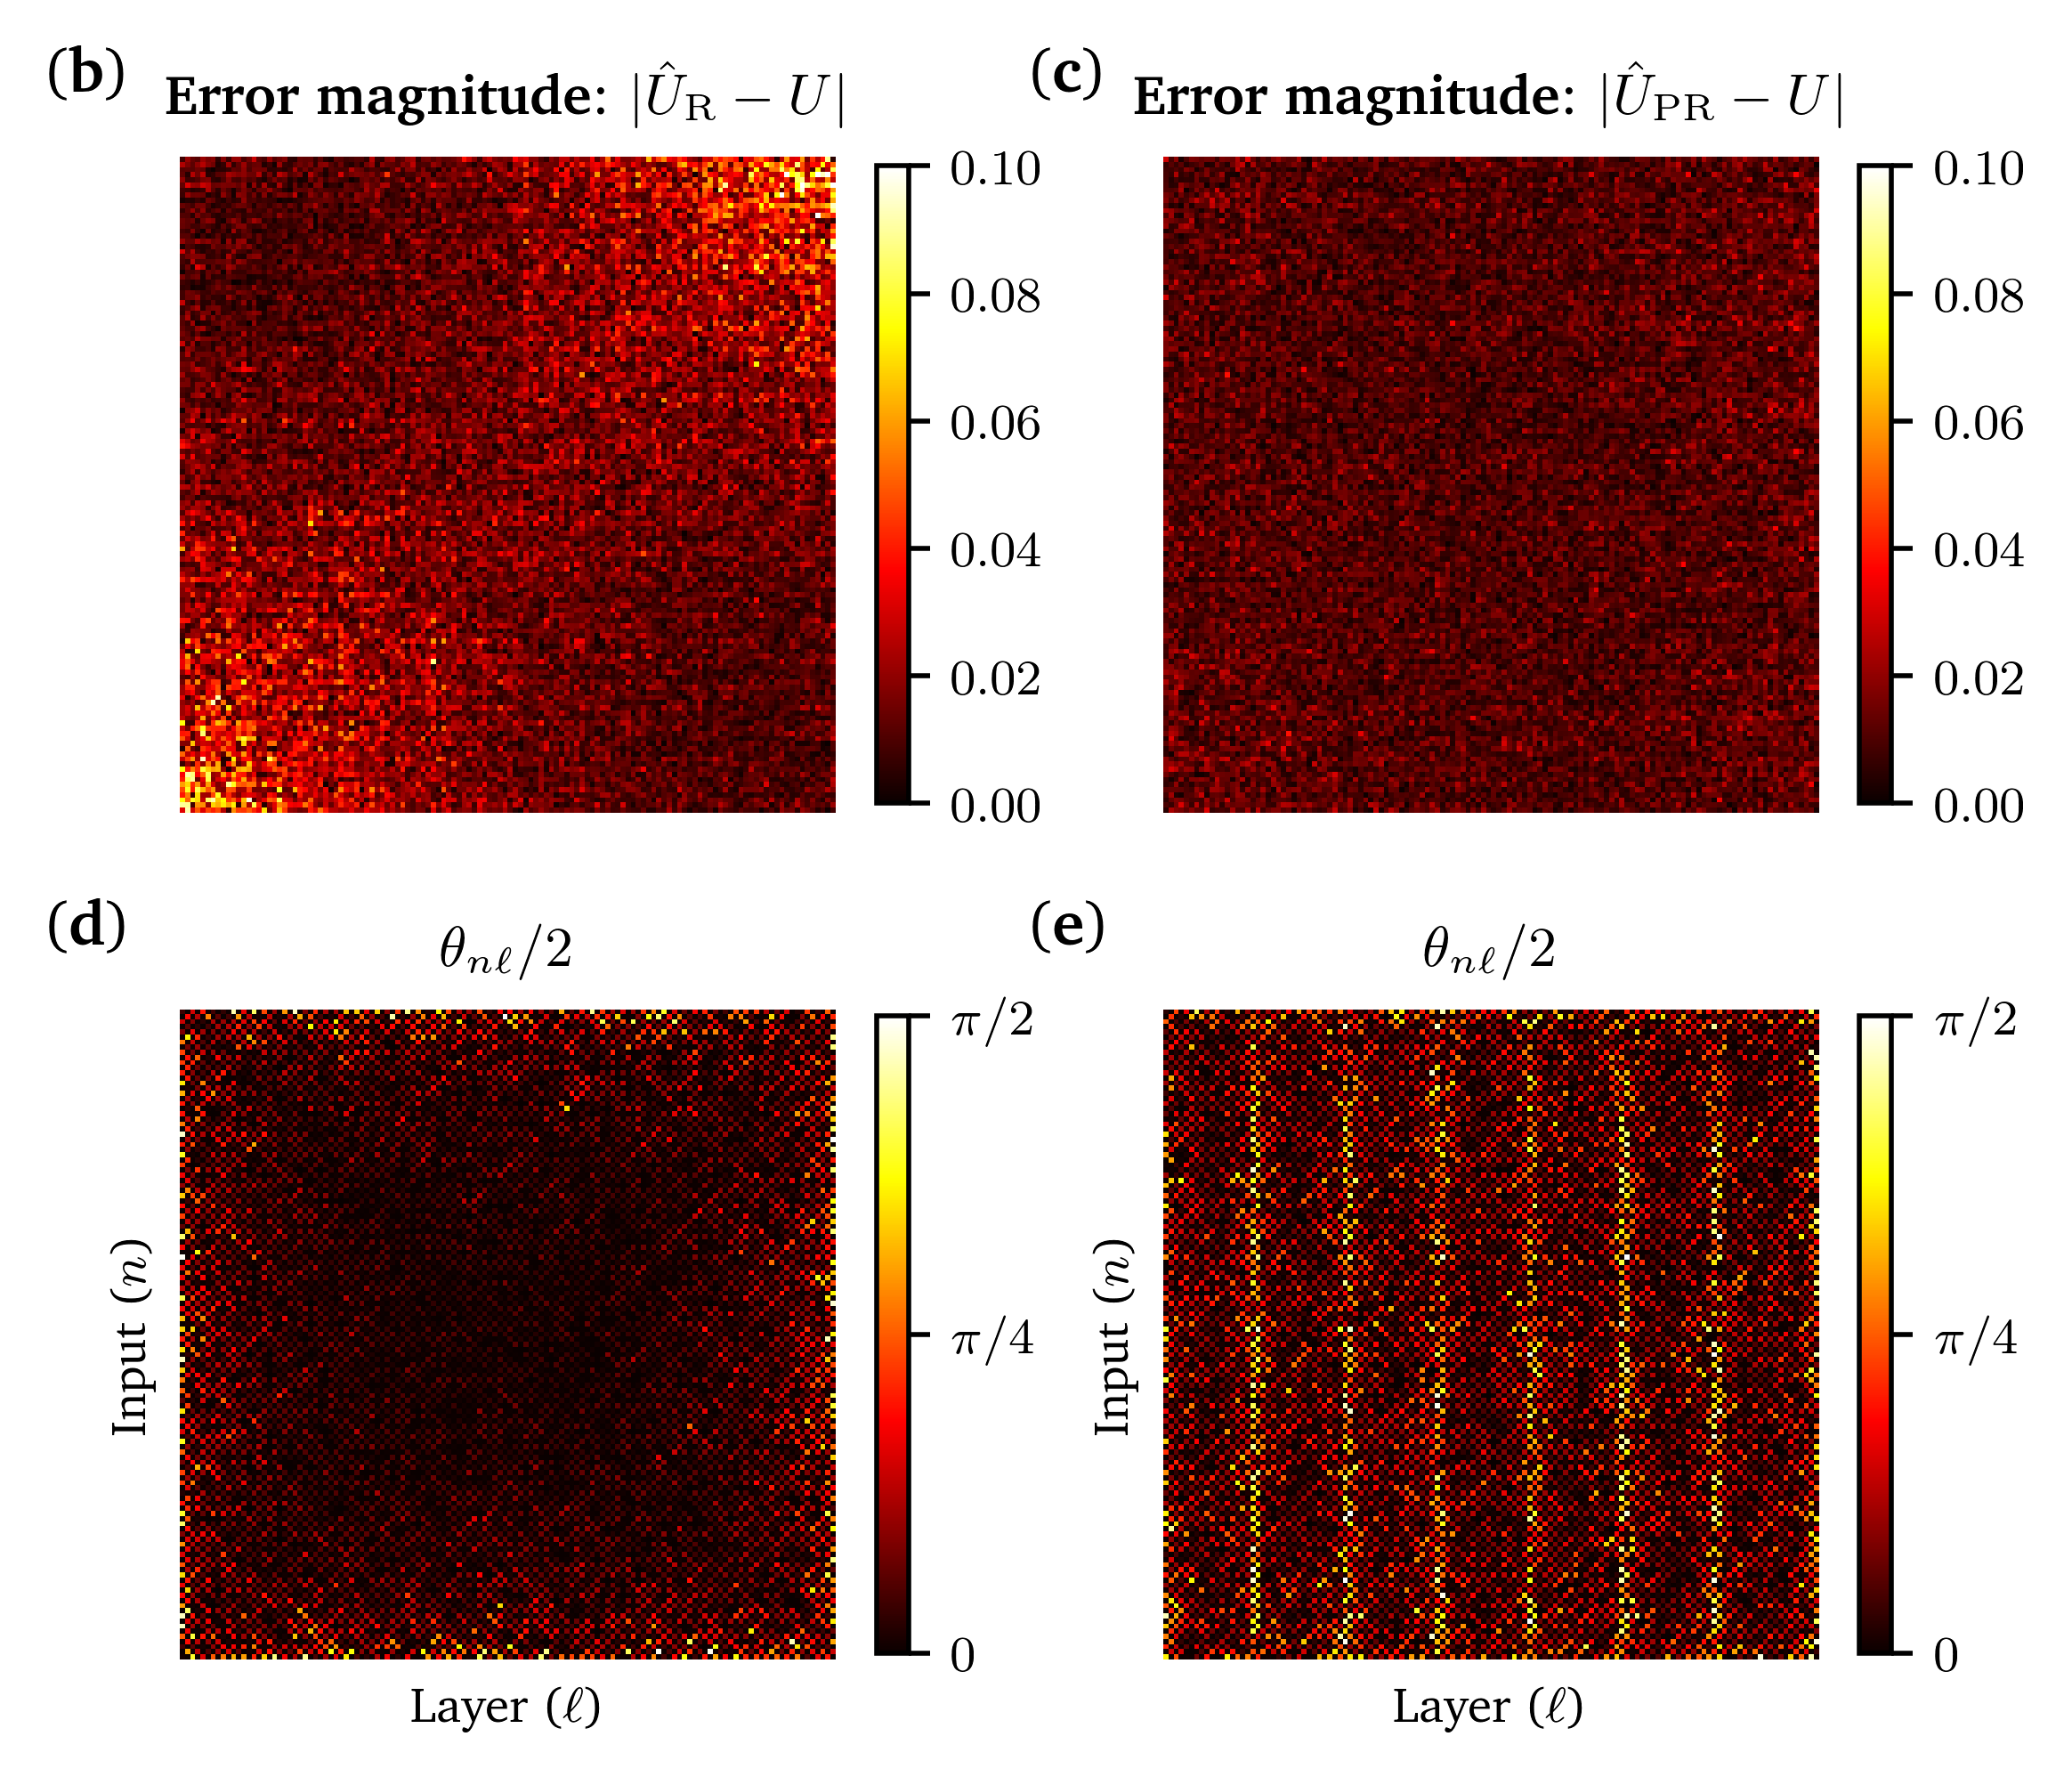

In [8]:
fig, axes = plt.subplots(2, 2, dpi=500)
rd_visualizer = MOResultsVisualizer('rm', rm_prm_results['results']['rm-default'], label_fontsize=8, title_fontsize=9)
rd_visualizer.plot_theta_checkerboard(axes[1, 0], plt, -1, cbar_shrink=0.9)
axes[1, 0].text(-0.2, 1.1, r'(\textbf{d})', transform=axes[1, 0].transAxes, size=10)
rd_visualizer.plot_error(axes[0, 0], plt, -1, clim=(0, 0.1), cbar_shrink=0.9)
axes[0, 0].text(-0.2, 1.1, r'(\textbf{b})', transform=axes[0, 0].transAxes, size=10)
cgrd_visualizer = MOResultsVisualizer('prm', rm_prm_results['results']['prm-default'], label_fontsize=8, title_fontsize=9)
cgrd_visualizer.plot_theta_checkerboard(axes[1, 1], plt, -1, cbar_shrink=0.9)
axes[1, 1].text(-0.2, 1.1, r'(\textbf{e})', transform=axes[1, 1].transAxes, size=10)
cgrd_visualizer.plot_error(axes[0, 1], plt, -1, clim=(0, 0.1), cbar_shrink=0.9)
axes[0, 1].text(-0.2, 1.1, r'(\textbf{c})', transform=axes[0, 1].transAxes, size=10)
plt.subplots_adjust(top=1, right=0.8)
plt.savefig('data/figures/6b_rm_prm_data.pdf', bbox_inches='tight', pad_inches=0.02)

## Experiment 2: Add redundancy (RRM) ([Figure 7 and Figure 10](https://arxiv.org/pdf/1808.00458))

Redundant rectangular meshes (RRM) involves simply adding vertical layers to the rectangular mesh. This experiment takes about 3 hours on an NVIDIA GTX1080 GPU.

### Experiment

In [10]:
if RUN_OPTIMIZATION:
    layers = [
        RM(N, N + N // 8), RM(N, N + N // 4), RM(N, N + N // 2), RM(N, 2 * N), RM(N, 2 * N, bs_error=0.1)
    ]

    layer_names = [
        "rrm-16-default", "rrm-32-default", "rrm-64-default", "rrm-128-default", "rrm-128-error"
    ]

    mr = LinearMultiModelRunner(experiment_name=f"rrm-{N}",
                                layer_names=layer_names,
                                layers=layers,
                                optimizer=tf.keras.optimizers.Adam(lr=0.0025),
                                batch_size=2 * N,
                                iterations_per_epoch=100,
                                iterations_per_tb_update=5,
                                logdir="/data/tensorboard/neurophox/")

    mr.run(200, target, pbar)
    mr.save("data/")

with open('data/rrm-128.p', 'rb') as f:
    rrm_results = pickle.load(f)

### Plotting (Figure 7)

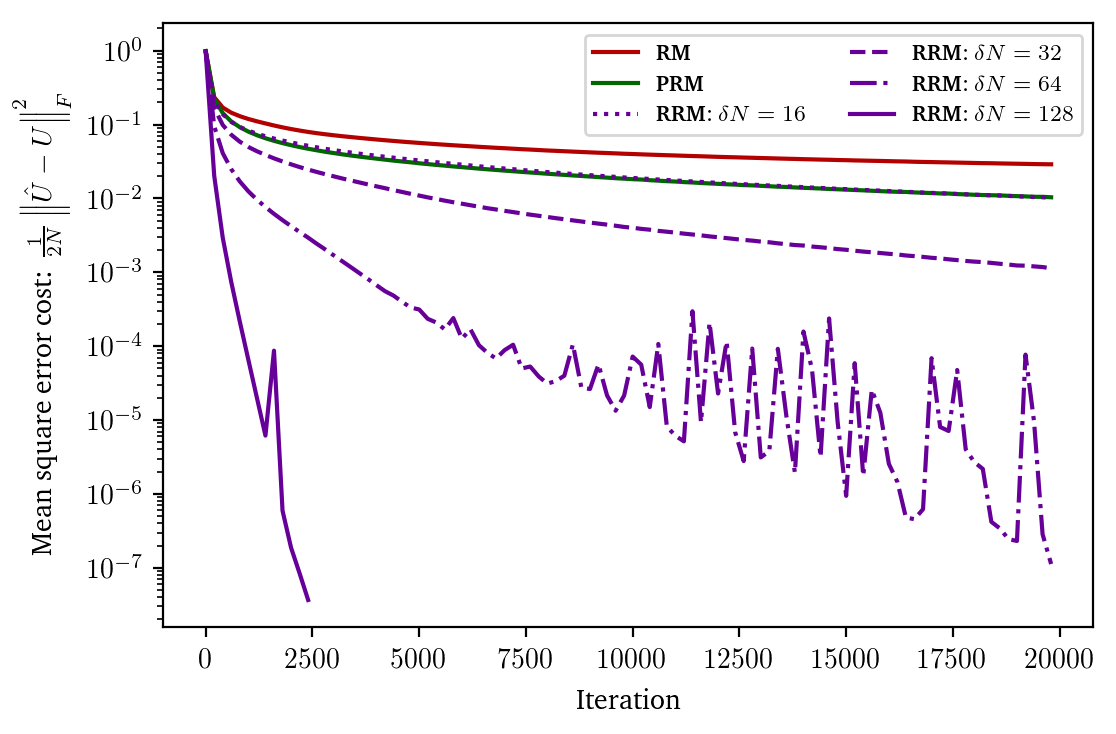

In [7]:
plt.figure(dpi=200)
plt.plot(200 * np.arange(100), np.asarray(rm_prm_results['losses']['rm-default'][::200]), color=[0.7, 0, 0])
plt.plot(200 * np.arange(100), np.asarray(rm_prm_results['losses']['prm-default'][::200]), color=[0, 0.4, 0])
linestyles = [':', '--', '-.']
for i, name in enumerate(rrm_results['losses']):
    if 'random' in name:
        linestyle = 'dotted'
    elif 'photonic' in name:
        linestyle = '--'
    else:
        linestyle = '-'
    if 'cgrd' in name:
        color=[0, 0.4, 0]
    elif 'rd' in name:
        color=[0.7, 0, 0]
    if '128' not in name:
        plt.plot(200 * np.arange(100), np.asarray(rrm_results['losses'][name][::200]), linestyle=linestyles[i], color=[0.4, 0, 0.6])
    elif 'error' not in name:
        plt.plot(200 * np.arange(13), np.asarray(rrm_results['losses'][name][::200][:13]), color=[0.4, 0, 0.6])
plt.xlabel('Iteration')
plt.ylabel(r'Mean square error cost: $\frac{1}{2N}\left\lVert\hat U - U\right\rVert_F^2$')
plt.legend([r'\textbf{RM}', r'\textbf{PRM}', r'\textbf{RRM}: $\delta N = 16$',
            r'\textbf{RRM}: $\delta N = 32$', r'\textbf{RRM}: $\delta N = 64$',
            r'\textbf{RRM}: $\delta N = 128$'], ncol=2, fontsize=8)
plt.yscale('log')
plt.savefig('data/figures/7_rrm_optimization.pdf', bbox_inches='tight', pad_inches=0.05)

### Plotting (Figure 10)

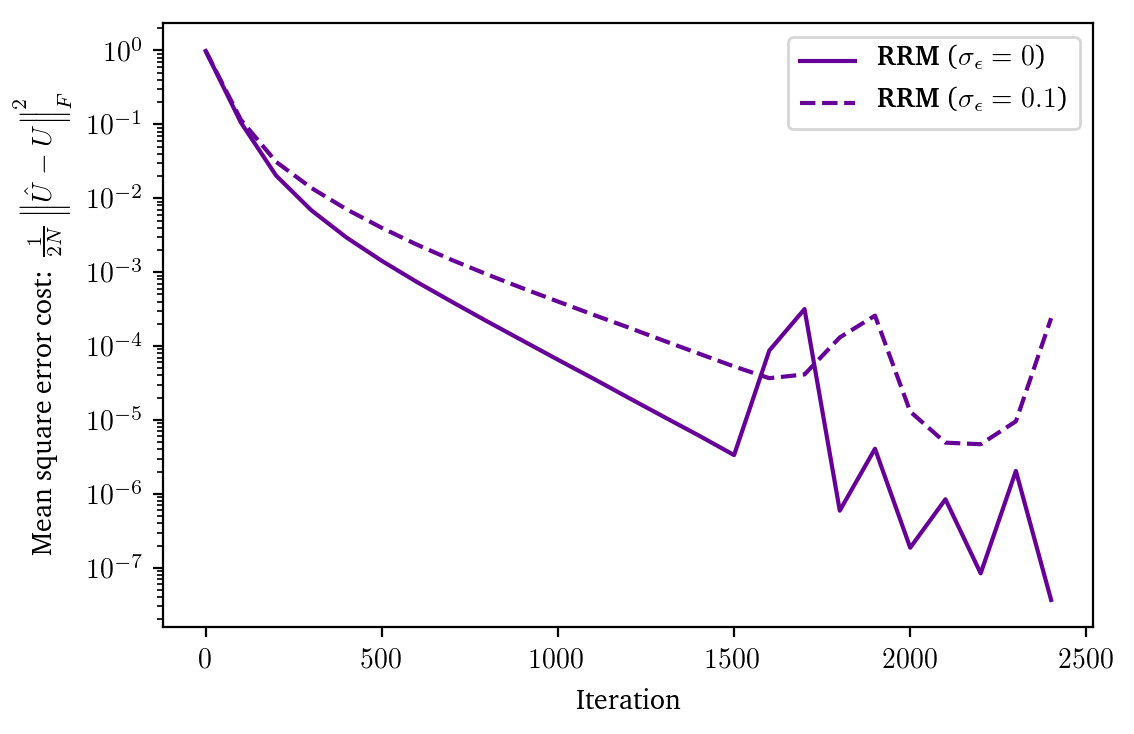

In [8]:
plt.figure(dpi=200)
plt.plot(100 * np.arange(25), np.asarray(rrm_results['losses']['rrm-128-default'][::100][:25]), color=[0.4, 0, 0.6])
plt.plot(100 * np.arange(25), np.asarray(rrm_results['losses']['rrm-128-error'][::100][:25]), color=[0.4, 0, 0.6], linestyle='--')
plt.xlabel('Iteration')
plt.yscale('log')
plt.ylabel(r'Mean square error cost: $\frac{1}{2N}\left\lVert\hat U - U\right\rVert_F^2$')
plt.legend([r'\textbf{RRM} ($\sigma_\epsilon = 0$)', r'\textbf{RRM} ($\sigma_\epsilon = 0.1$)'])
plt.savefig('data/figures/10_rrm_error_optimization.pdf', bbox_inches='tight', pad_inches=0.05)

## Experiment 3: SVD layers ([Figure 11](https://arxiv.org/pdf/1808.00458))

This experiment takes about 3.5 hours on an NVIDIA GTX1080 GPU. We find that the disparity seen between PRM and RM models for the unitary matrices is signficantly reduced for SVD optimization of a random matrix of iid standard normal complex-valued elements.

### Experiment

In [10]:
N = 64
target = np.random.randn(N, N) + 1j * np.random.randn(N, N)
if RUN_OPTIMIZATION:
    layers = [
        SVD(N, mesh_dict={"name": "rm"}),
        SVD(N, mesh_dict={"name": "rm", "properties":{"bs_error": 0.1}}),
        SVD(N, mesh_dict={"name": "rm", "properties":{"theta_init_name": "random_theta"}}),
        SVD(N, mesh_dict={"name": "prm"}),
        SVD(N, mesh_dict={"name": "prm", "properties":{"bs_error": 0.1}}),
        SVD(N, mesh_dict={"name": "prm", "properties":{"theta_init_name": "random_theta"}})
    ]

    layer_names = [
        "svdrm-default", "svdrm-error", "svdrm-rand", "svdprm-default", "svdprm-error", "svdprm-rand"
    ]

    mr = LinearMultiModelRunner(experiment_name=f"svd-{N}",
                                layer_names=layer_names,
                                layers=layers,
                                optimizer=tf.keras.optimizers.Adam(lr=0.005),
                                batch_size=2 * N,
                                iterations_per_epoch=100,
                                iterations_per_tb_update=5,
                                logdir="/data/tensorboard/neurophox/")

    mr.run(200, target, pbar)
    mr.save("data/")

with open('data/svd-64.p', 'rb') as f:
    svd_results = pickle.load(f)

### Plotting (Figure 11)

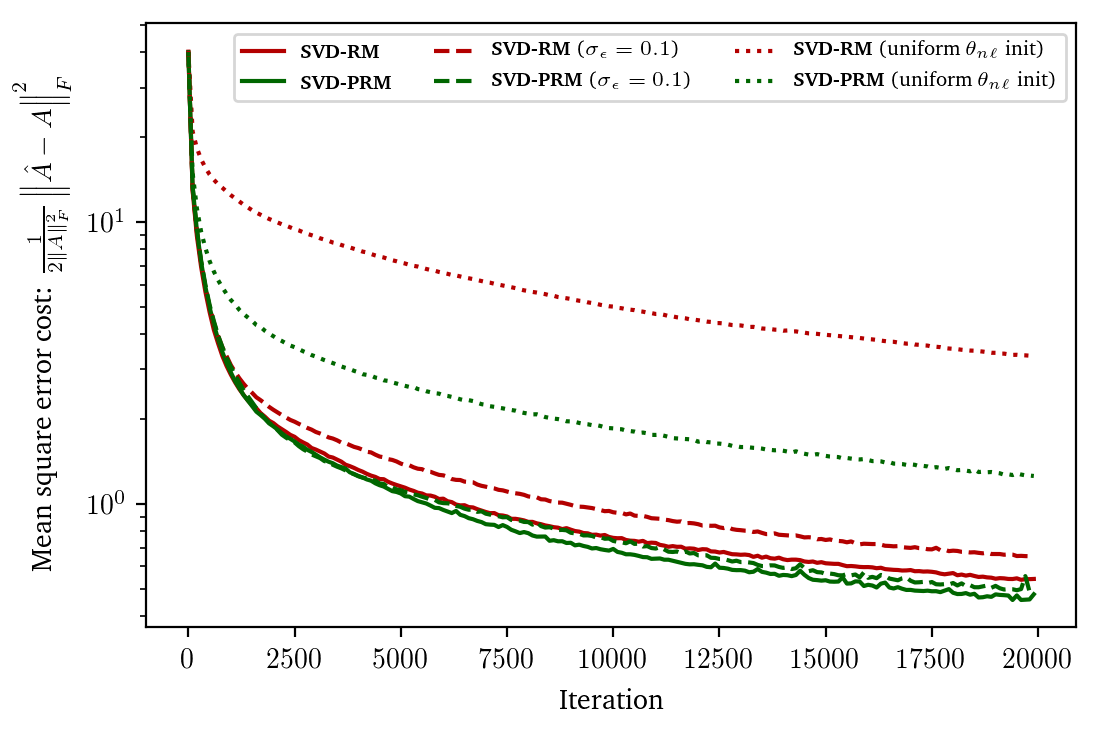

In [11]:
plt.figure(dpi=200)

# this interestingly is usually close to 2 based on target defined above (so we assume that )
# normalized_value = np.sum(np.abs(target) ** 2) / N  
normalized_value = 2

for name in ("svdrm-default", "svdprm-default", "svdrm-error", "svdprm-error", "svdrm-rand", "svdprm-rand"):
    if 'rand' in name:
        linestyle = 'dotted'
    elif 'error' in name:
        linestyle = '--'
    else:
        linestyle = '-'
    if 'prm' in name:
        color=[0, 0.4, 0]
    elif 'rm' in name:
        color=[0.7, 0, 0]
    plt.plot(np.arange(200) * 100, np.asarray(svd_results['losses'][name][::100]) / normalized_value, linestyle=linestyle, color=color)
plt.xlabel('Iteration')
plt.ylabel(r'Mean square error cost: $\frac{1}{2\|A\|_F^2} \left\lVert\hat A - A\right\rVert_F^2$')
plt.yscale('log')
plt.legend([r'\textbf{SVD-RM}', r'\textbf{SVD-PRM}',
            r'\textbf{SVD-RM} ($\sigma_\epsilon = 0.1$)',
            r'\textbf{SVD-PRM} ($\sigma_\epsilon = 0.1$)',
            r'\textbf{SVD-RM} (uniform $\theta_{n\ell}$ init)',
            r'\textbf{SVD-PRM} (uniform $\theta_{n\ell}$ init)'], ncol=3, fontsize=7.5)
plt.savefig('data/figures/11_svd_optimization.pdf', bbox_inches='tight', pad_inches=0.02)

## Visualize with Tensorboard!

It is possible to embed `tensorboard` in your notebook to track the optimization losses in real time. This acts as a sanity check as you run your experiments. (You may need to run this cell twice to see the iframe.)

In [10]:
%load_ext tensorboard
%tensorboard --logdir /data/tensorboard/neurophox

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 15592), started 0:00:02 ago. (Use '!kill 15592' to kill it.)

## More plots for Experiment 1 ([Figure 12](https://arxiv.org/pdf/1808.00458))

**Prerequisite:** Load Experiment 1 data or get pickle file results by running the appropriate code above.

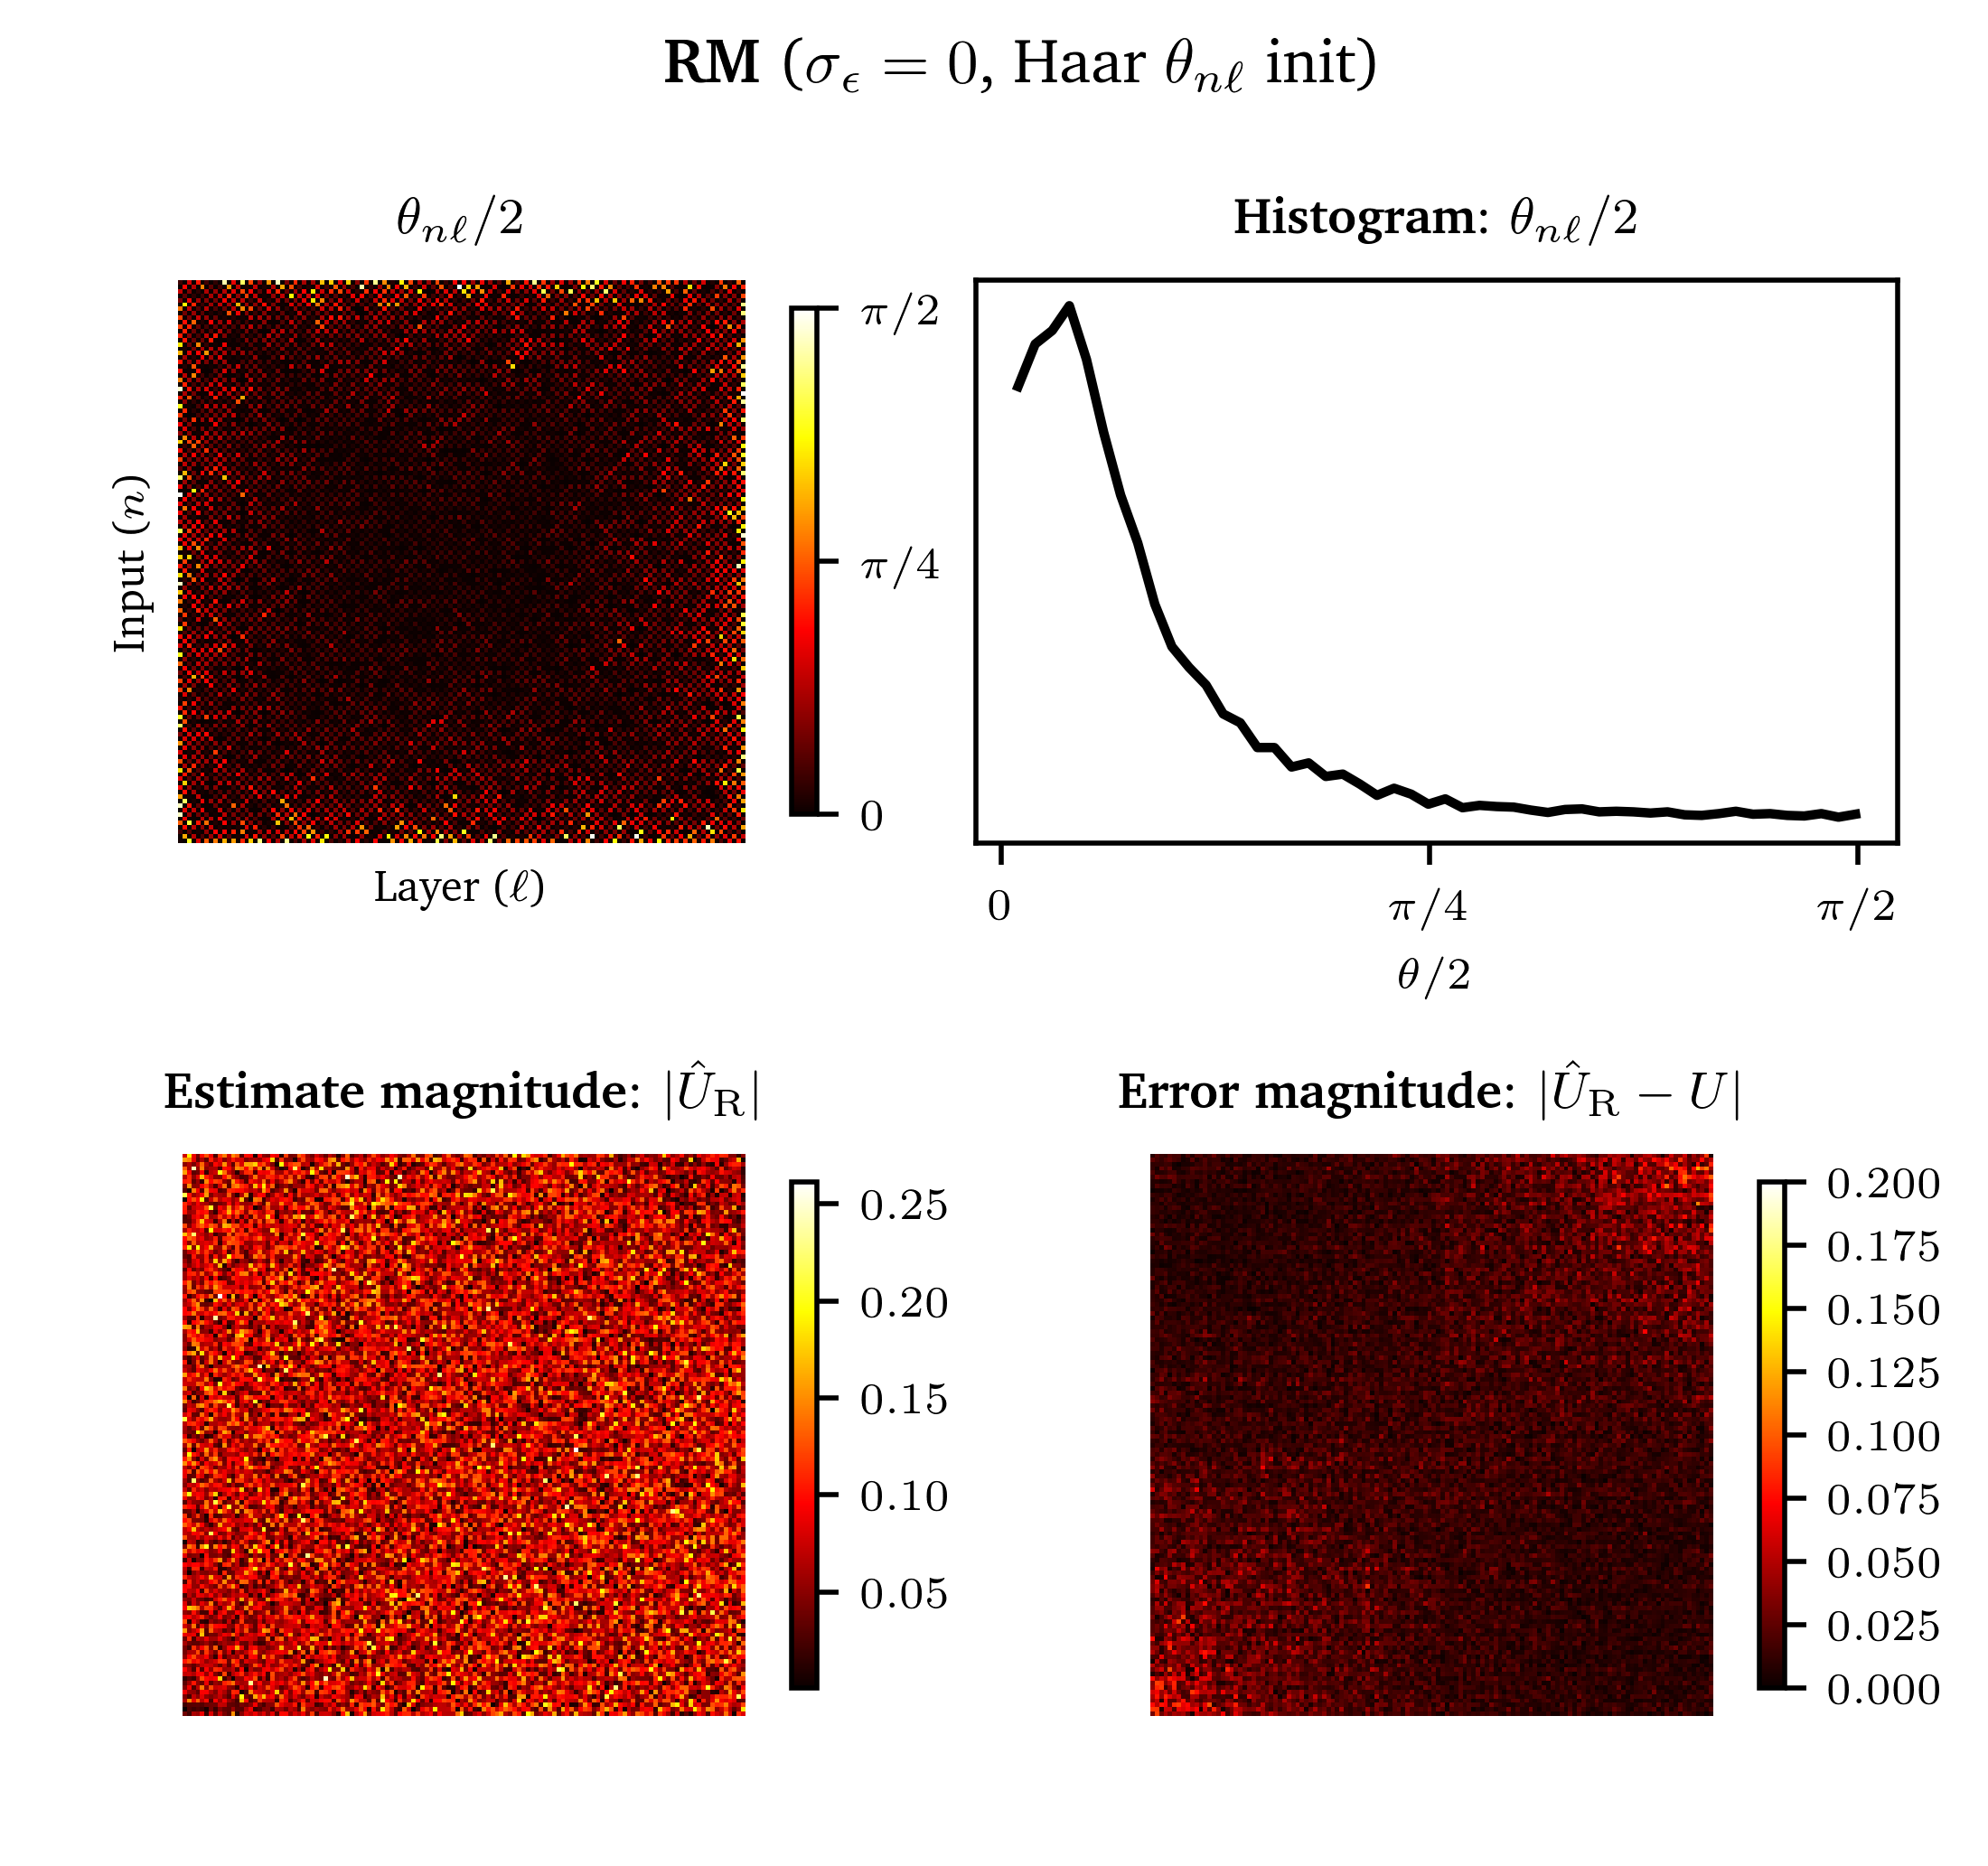

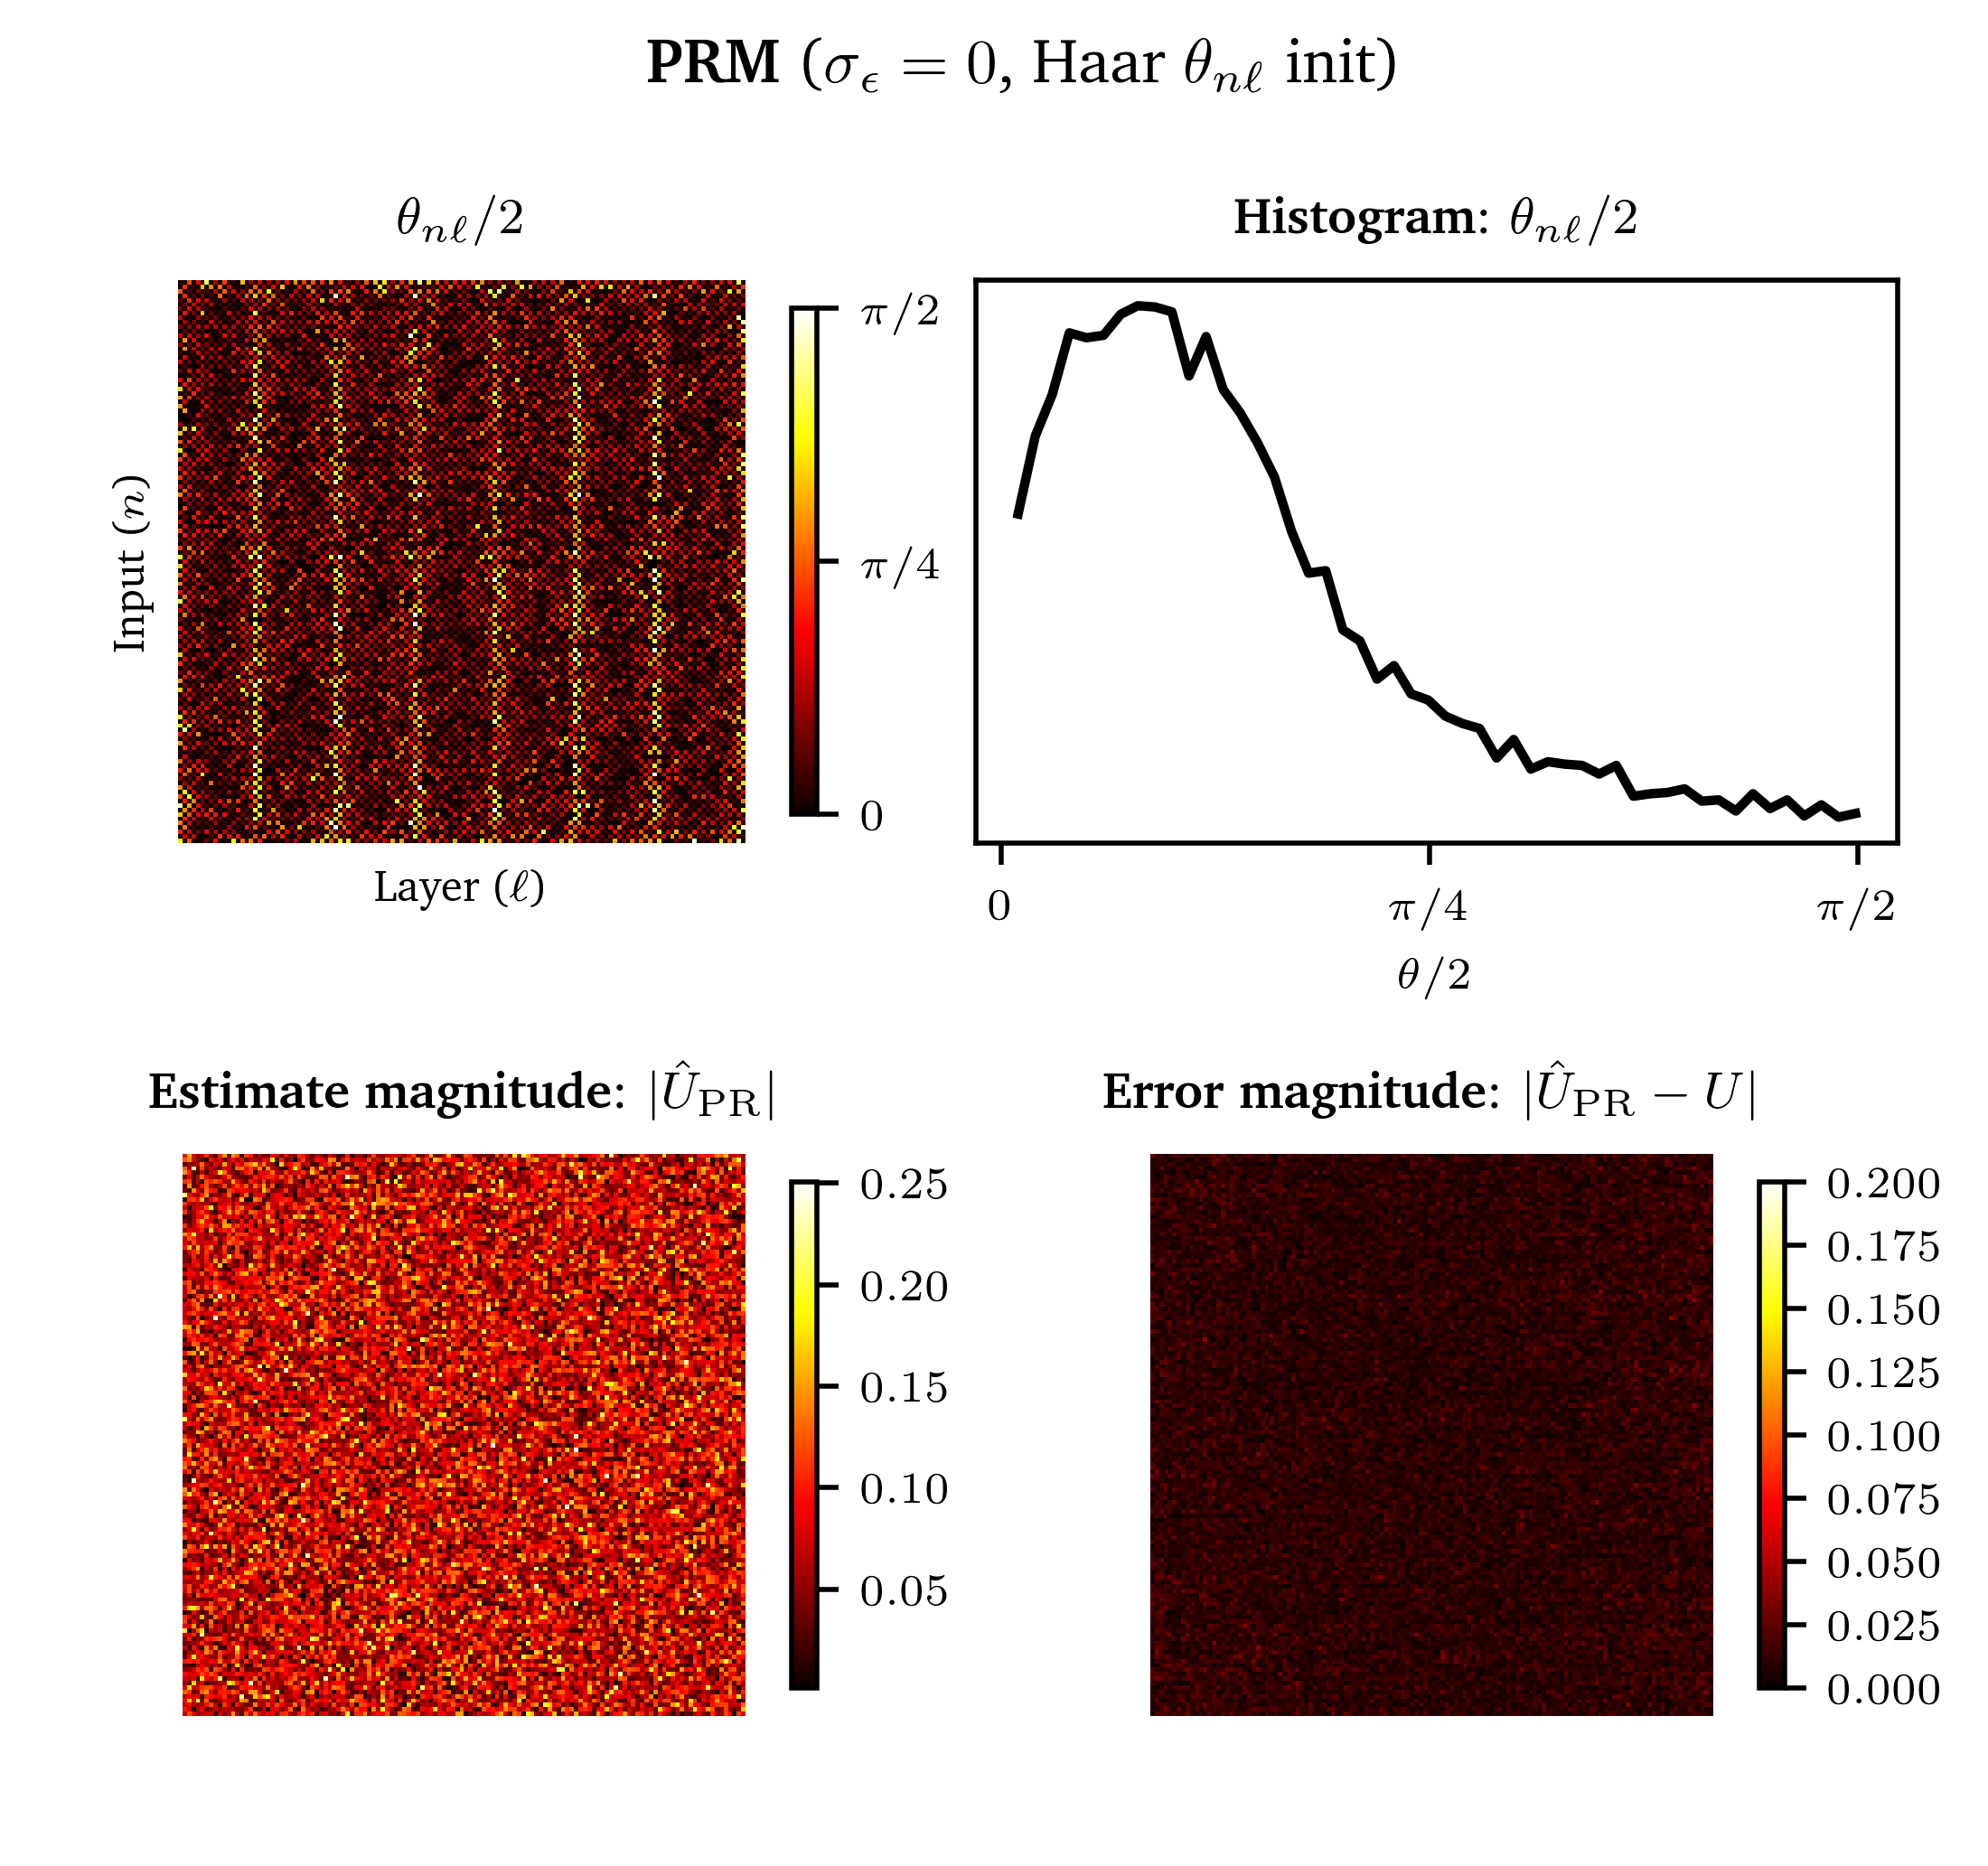

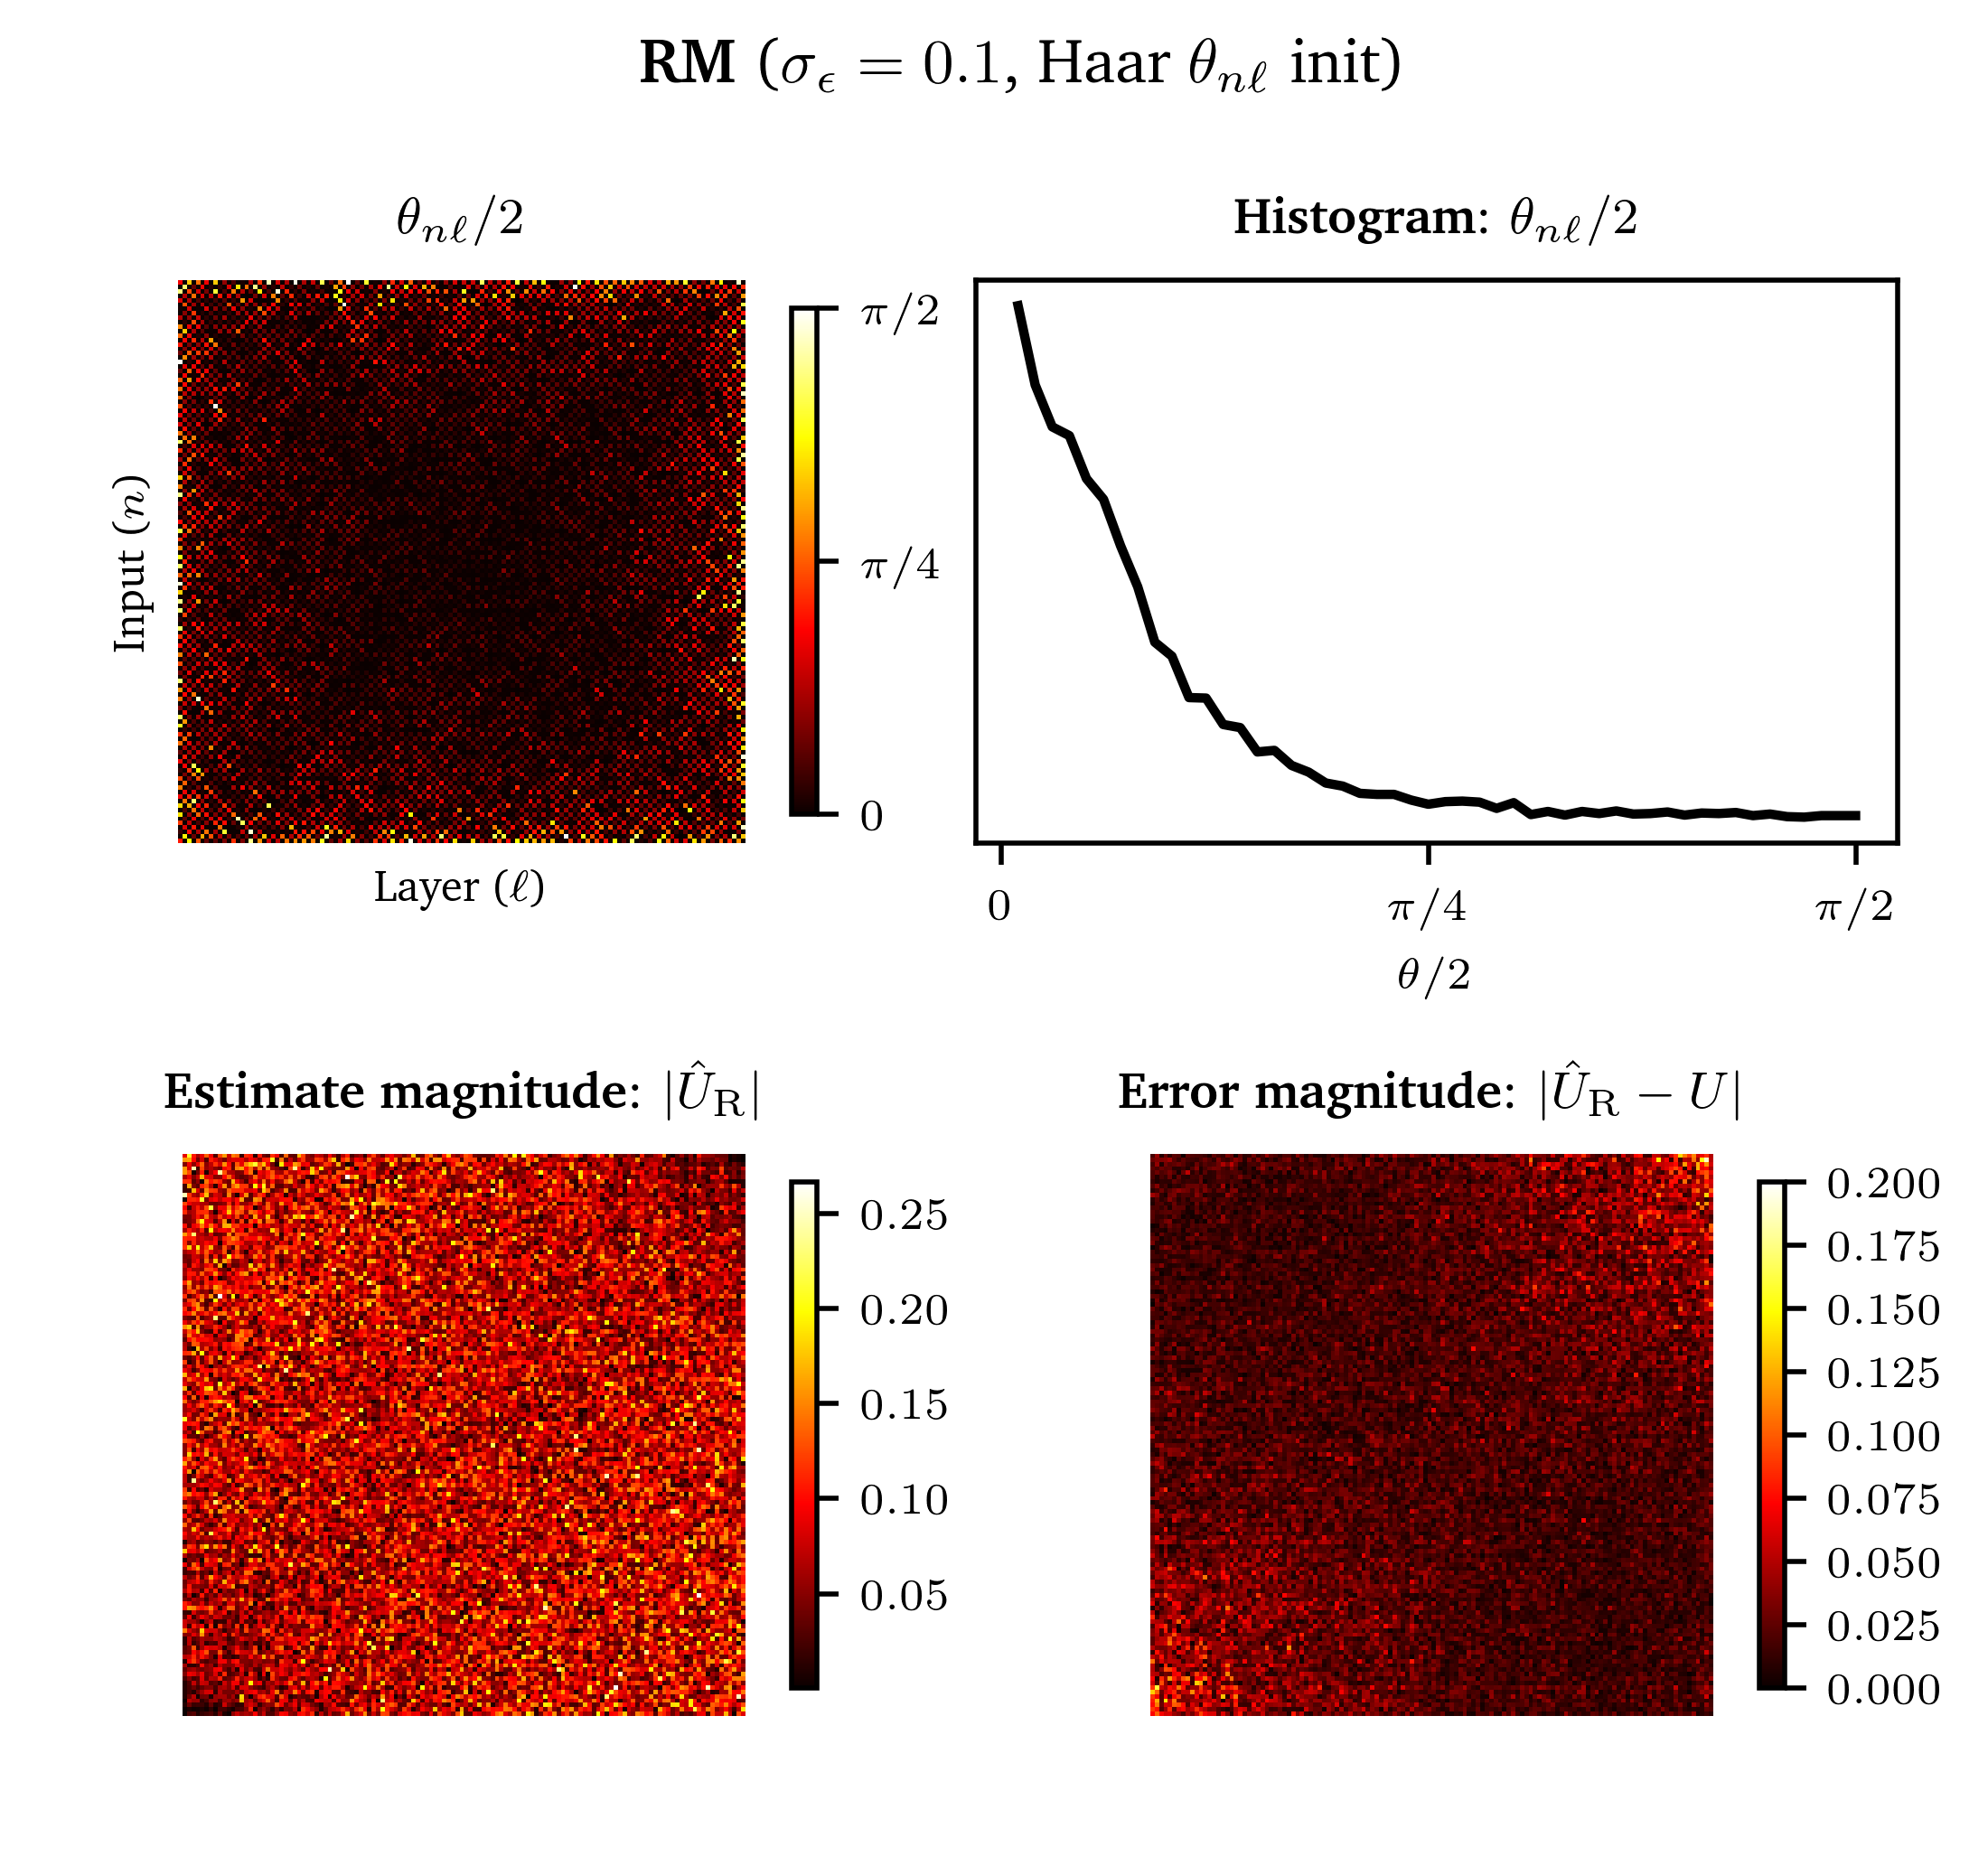

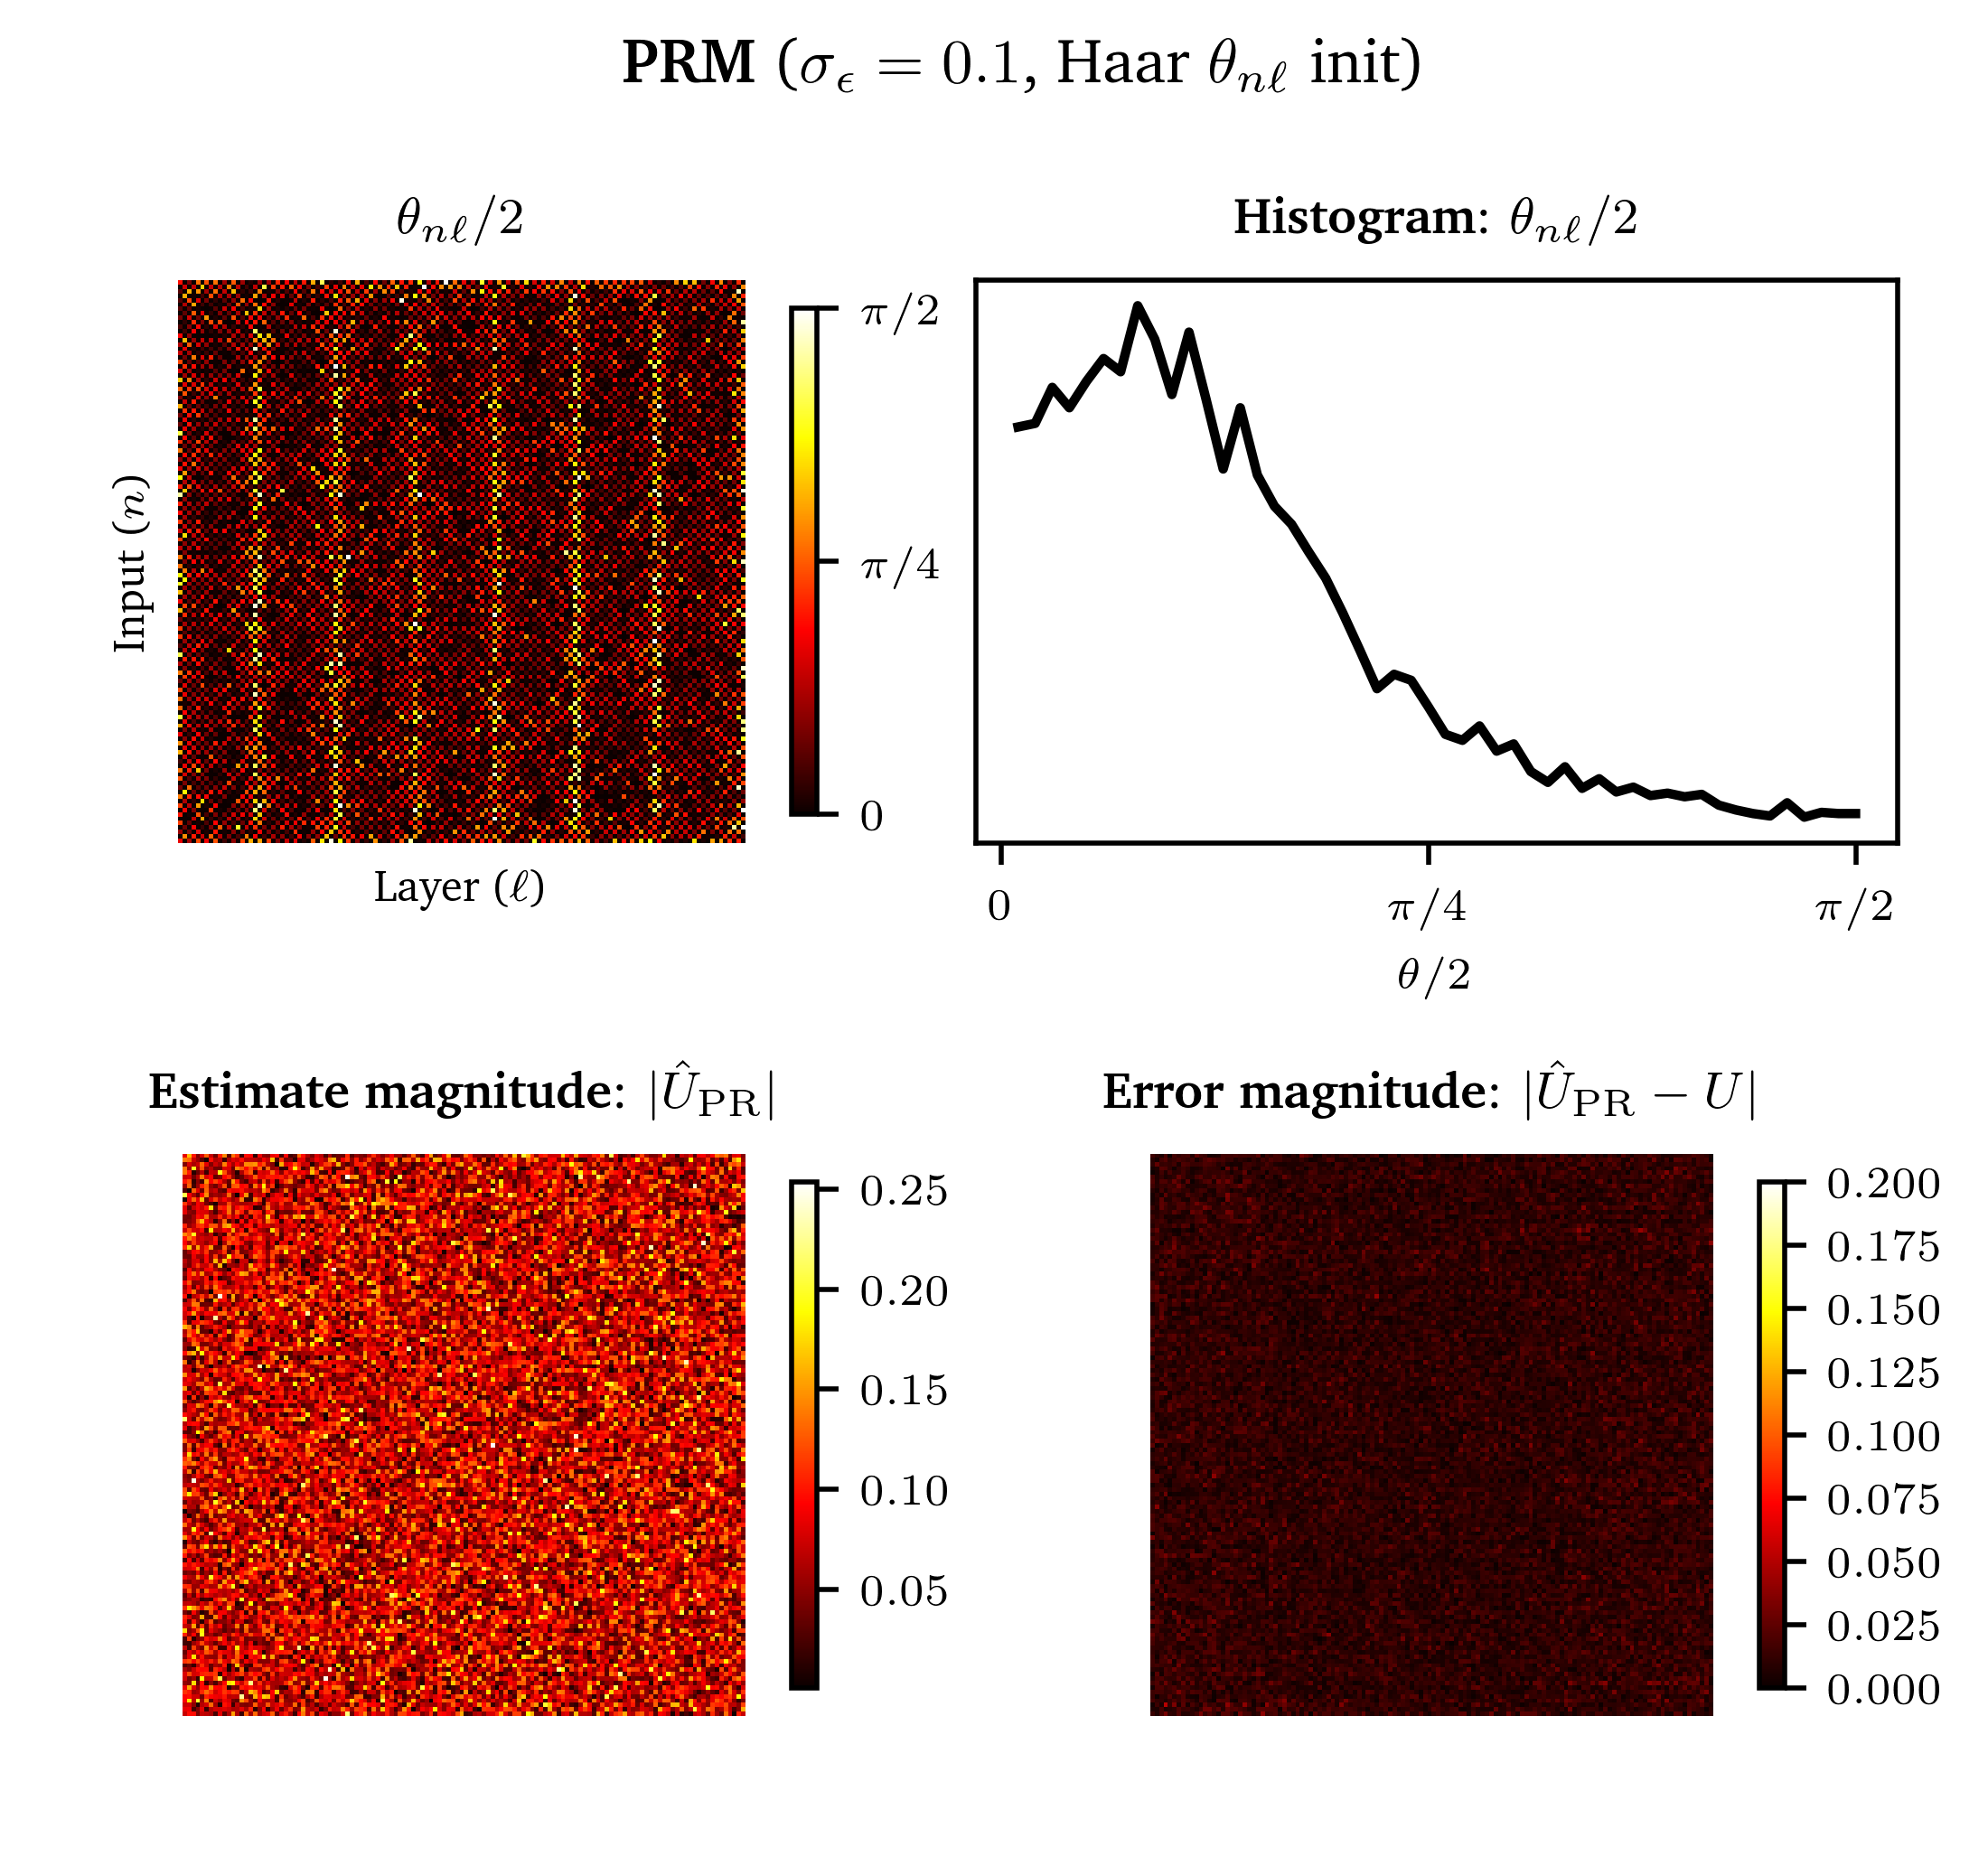

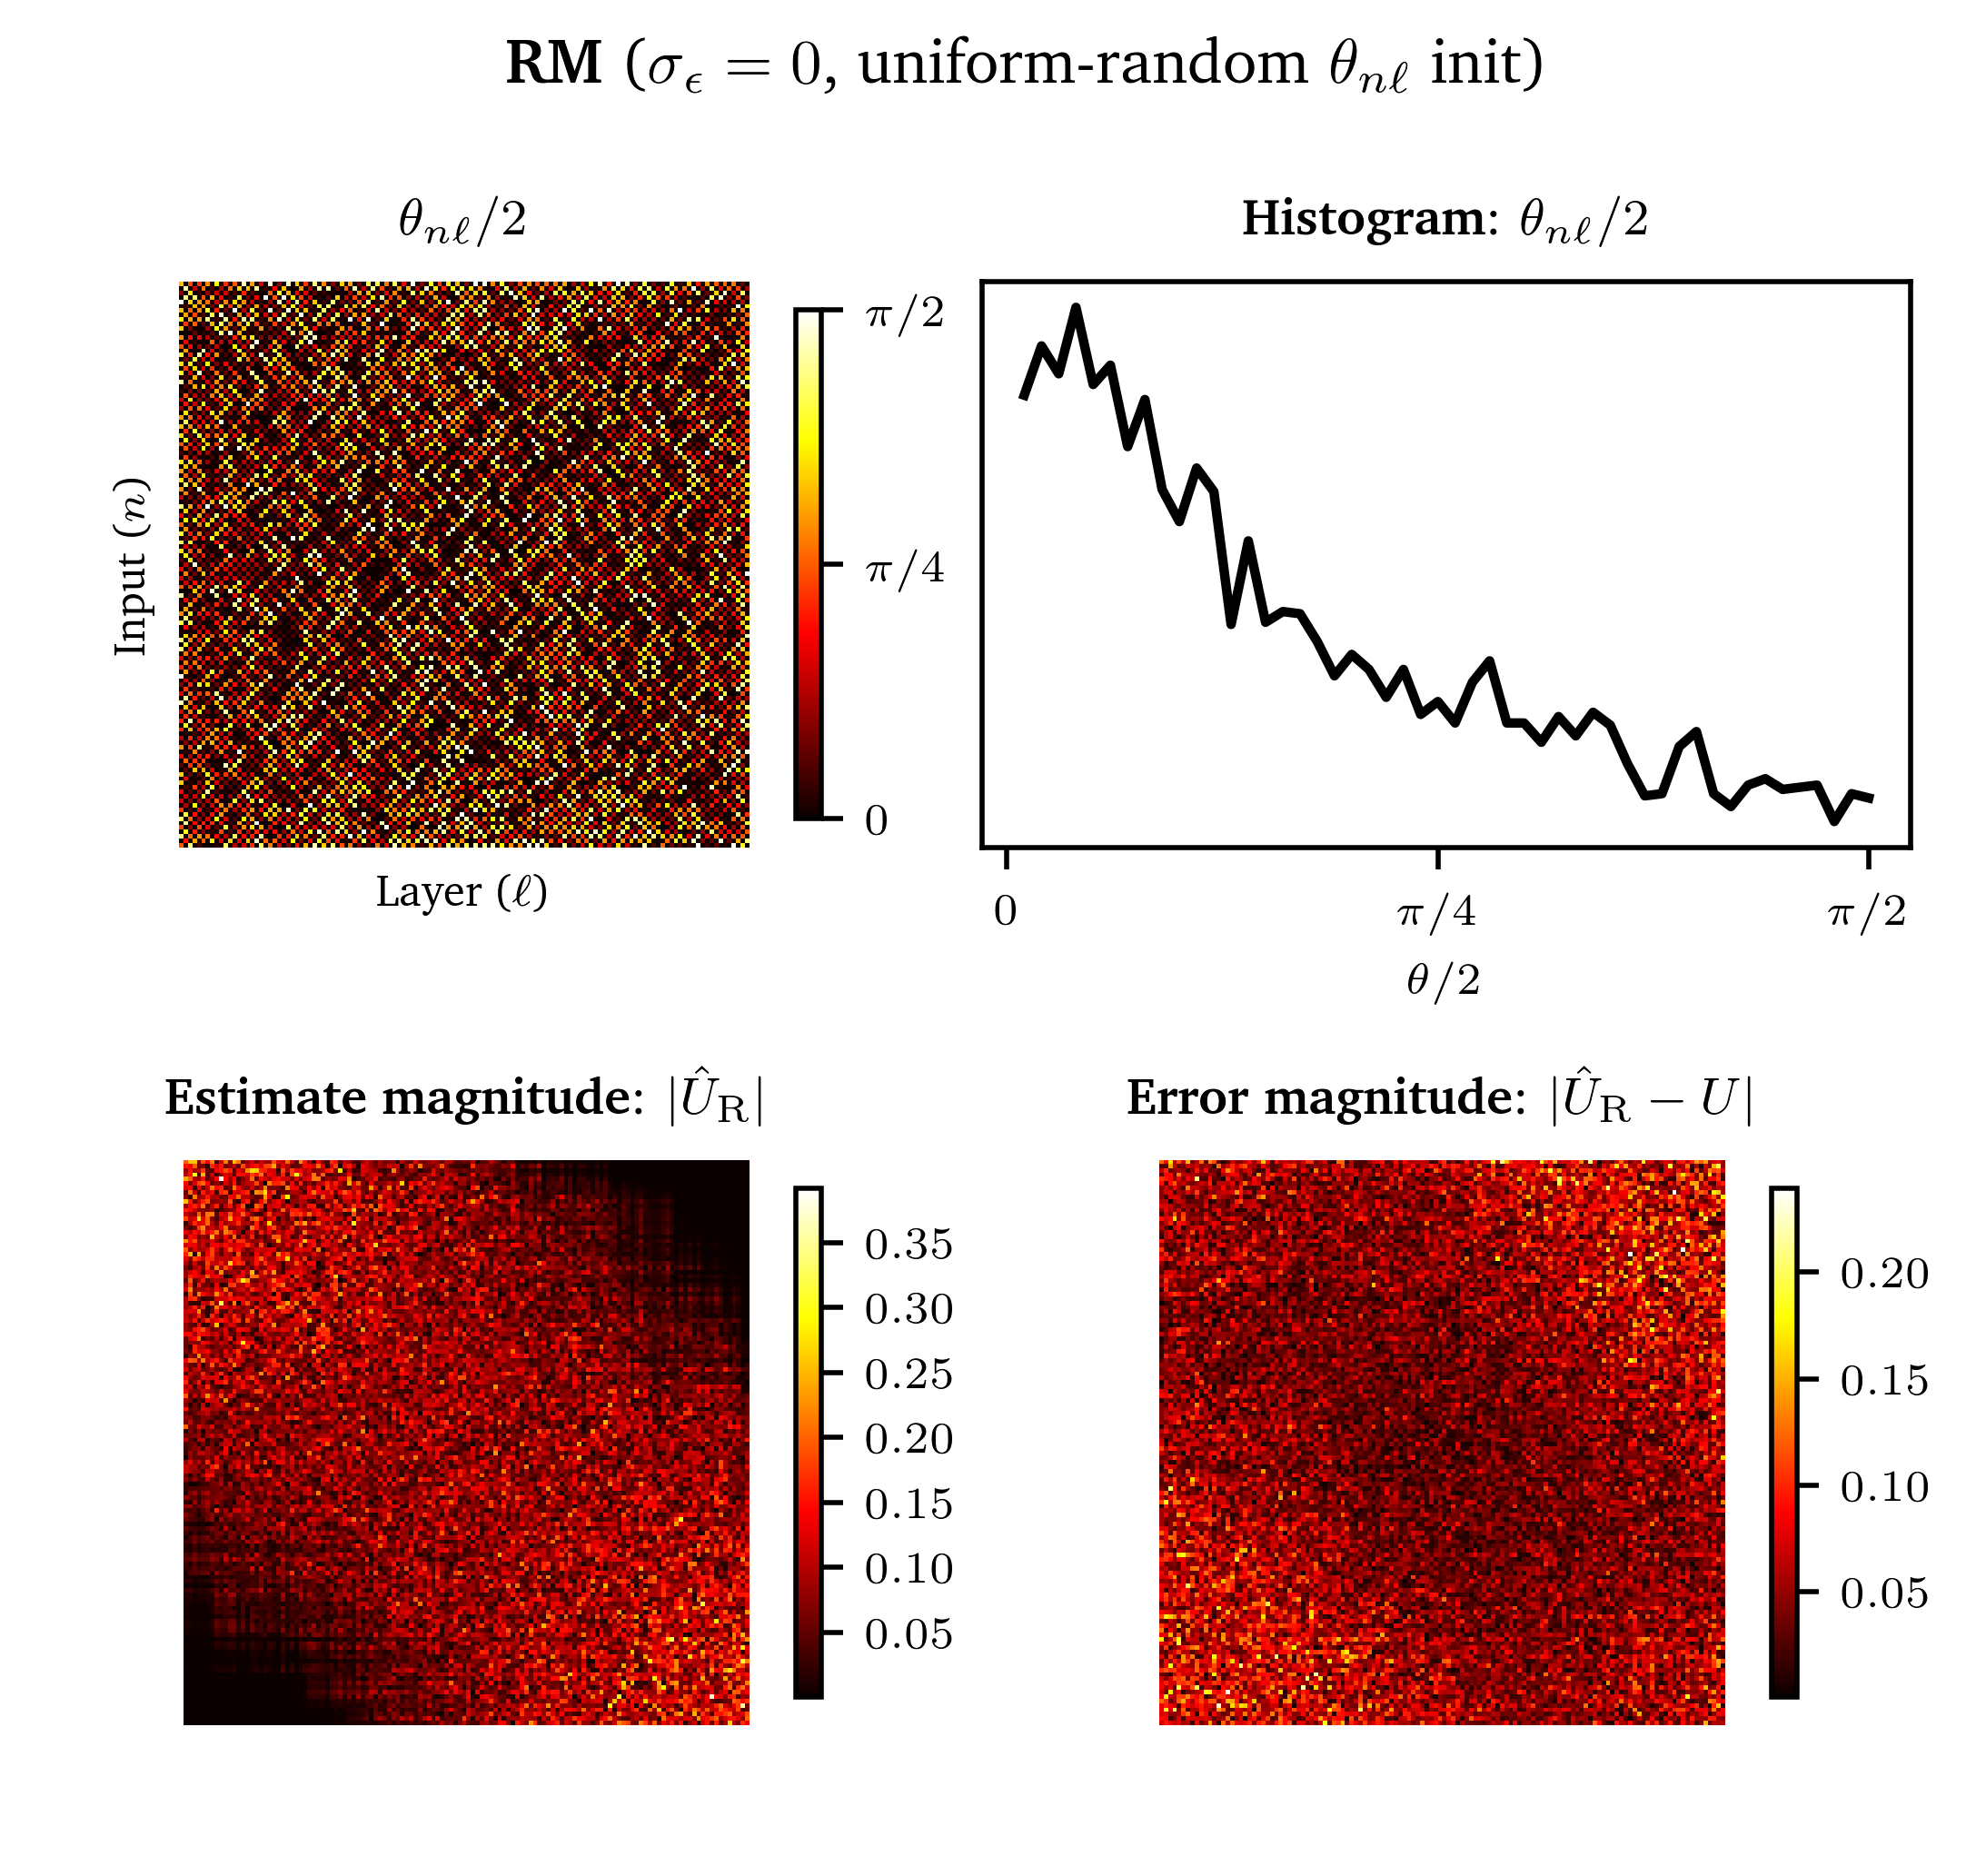

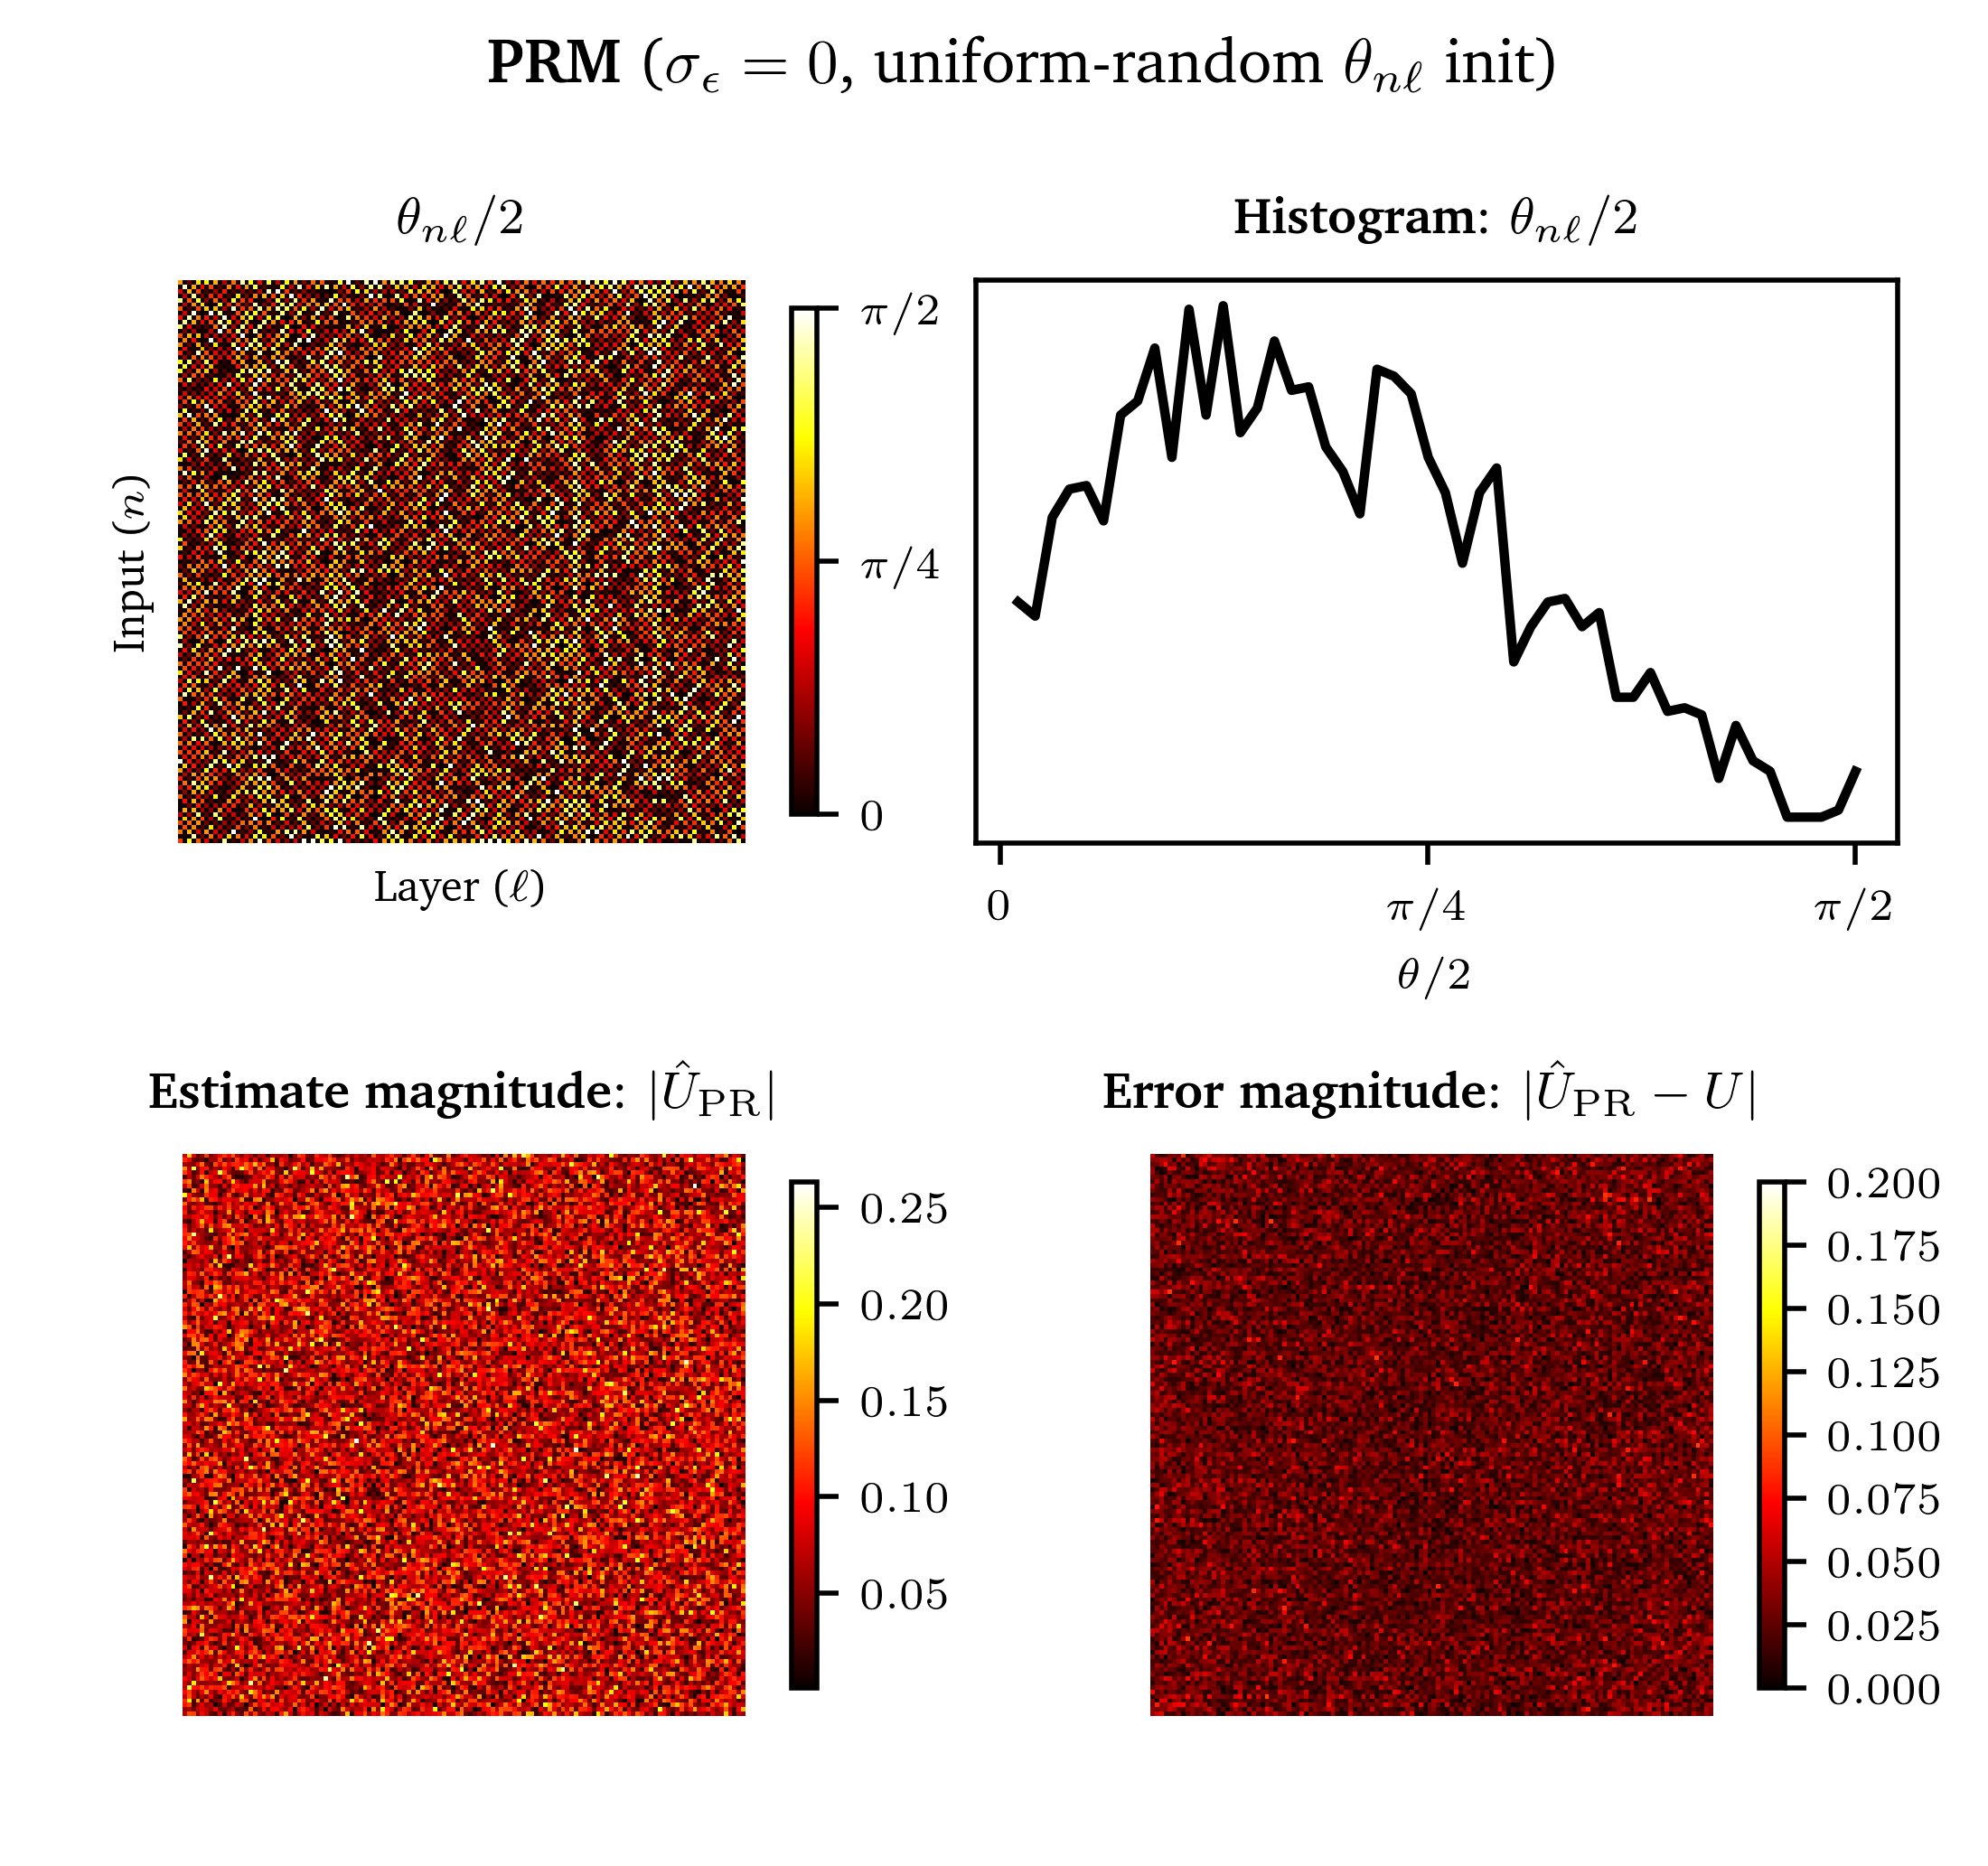

In [5]:
def plot_results(name, filename, title):
    sun_results_visualizer = MOResultsVisualizer(name, rm_prm_results['results'][name])
    sun_results_visualizer.plot_meaningful_snapshot(plt, -1, cbar_shrink=0.9)
    plt.suptitle(title, fontsize=10, horizontalalignment='center', x=0.1, y=1.05)
    plt.subplots_adjust(top=0.95, right=1.1)
    plt.tight_layout(rect=[-0.3, 0.03, 0.45, 1])
    plt.savefig(f'data/figures/{filename}.pdf', bbox_inches='tight', pad_inches=0.05)
plot_results('rm-default', '12a_sun_rm', r'\textbf{RM} ($\sigma_\epsilon = 0$, Haar $\theta_{n\ell}$ init)')
plot_results('prm-default', '12b_sun_prm', r'\textbf{PRM} ($\sigma_\epsilon = 0$, Haar $\theta_{n\ell}$ init)')
plot_results('rm-error', '12c_sun_rm_error', r'\textbf{RM} ($\sigma_\epsilon = 0.1$, Haar $\theta_{n\ell}$ init)')
plot_results('prm-error', '12d_sun_prm_error', r'\textbf{PRM} ($\sigma_\epsilon = 0.1$, Haar $\theta_{n\ell}$ init)')
plot_results('rm-rand', '12e_sun_rm_random', r'\textbf{RM} ($\sigma_\epsilon = 0$, uniform-random $\theta_{n\ell}$ init)')
plot_results('prm-rand', '12f_sun_prm_random', r'\textbf{PRM} ($\sigma_\epsilon = 0$, uniform-random $\theta_{n\ell}$ init)')

## Make [movies](https://av.tib.eu/series/520/photonic+optimization) to analyze optimization

**Prerequisite:** Load Experiment 1 data or get pickle file results by running the appropriate code above.

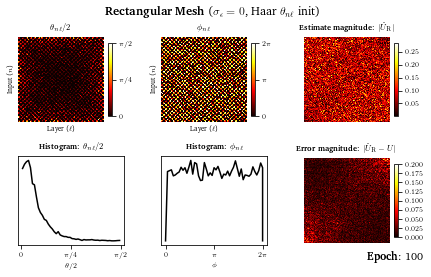

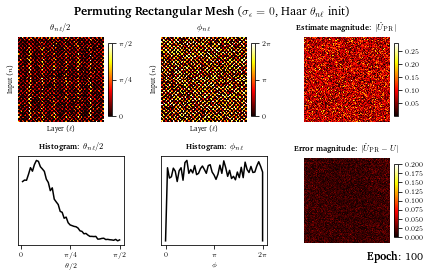

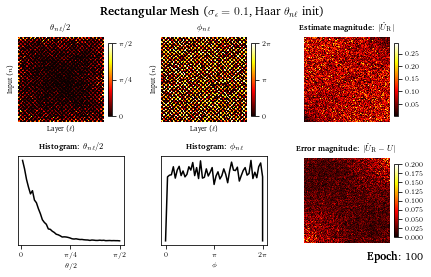

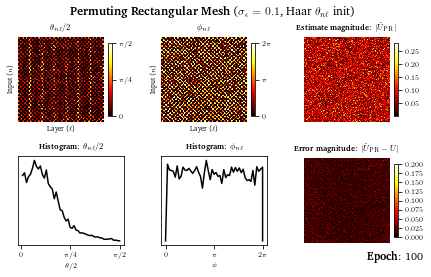

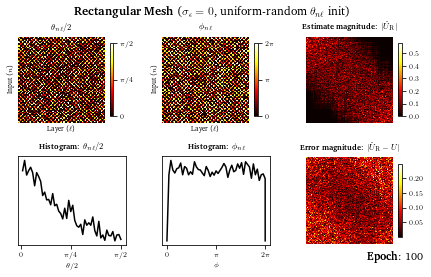

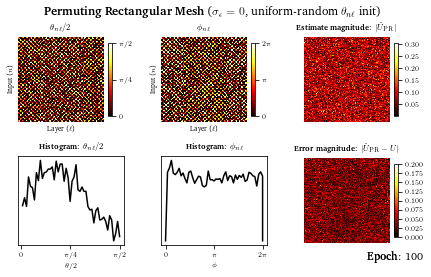

In [5]:
def plot_movie(name, title):
    sun_results_visualizer = MOResultsVisualizer(name, rm_prm_results['results'][name])
    sun_results_visualizer.plot_movie(plt, title, save_path='data/movies/', pbar_handle=pbar)
plot_movie('rm-default', r'\textbf{Rectangular Mesh} ($\sigma_\epsilon = 0$, Haar $\theta_{n\ell}$ init)')
plot_movie('prm-default', r'\textbf{Permuting Rectangular Mesh} ($\sigma_\epsilon = 0$, Haar $\theta_{n\ell}$ init)')
plot_movie('rm-error', r'\textbf{Rectangular Mesh} ($\sigma_\epsilon = 0.1$, Haar $\theta_{n\ell}$ init)')
plot_movie('prm-error', r'\textbf{Permuting Rectangular Mesh} ($\sigma_\epsilon = 0.1$, Haar $\theta_{n\ell}$ init)')
plot_movie('rm-rand', r'\textbf{Rectangular Mesh} ($\sigma_\epsilon = 0$, uniform-random $\theta_{n\ell}$ init)')
plot_movie('prm-rand', r'\textbf{Permuting Rectangular Mesh} ($\sigma_\epsilon = 0$, uniform-random $\theta_{n\ell}$ init)')

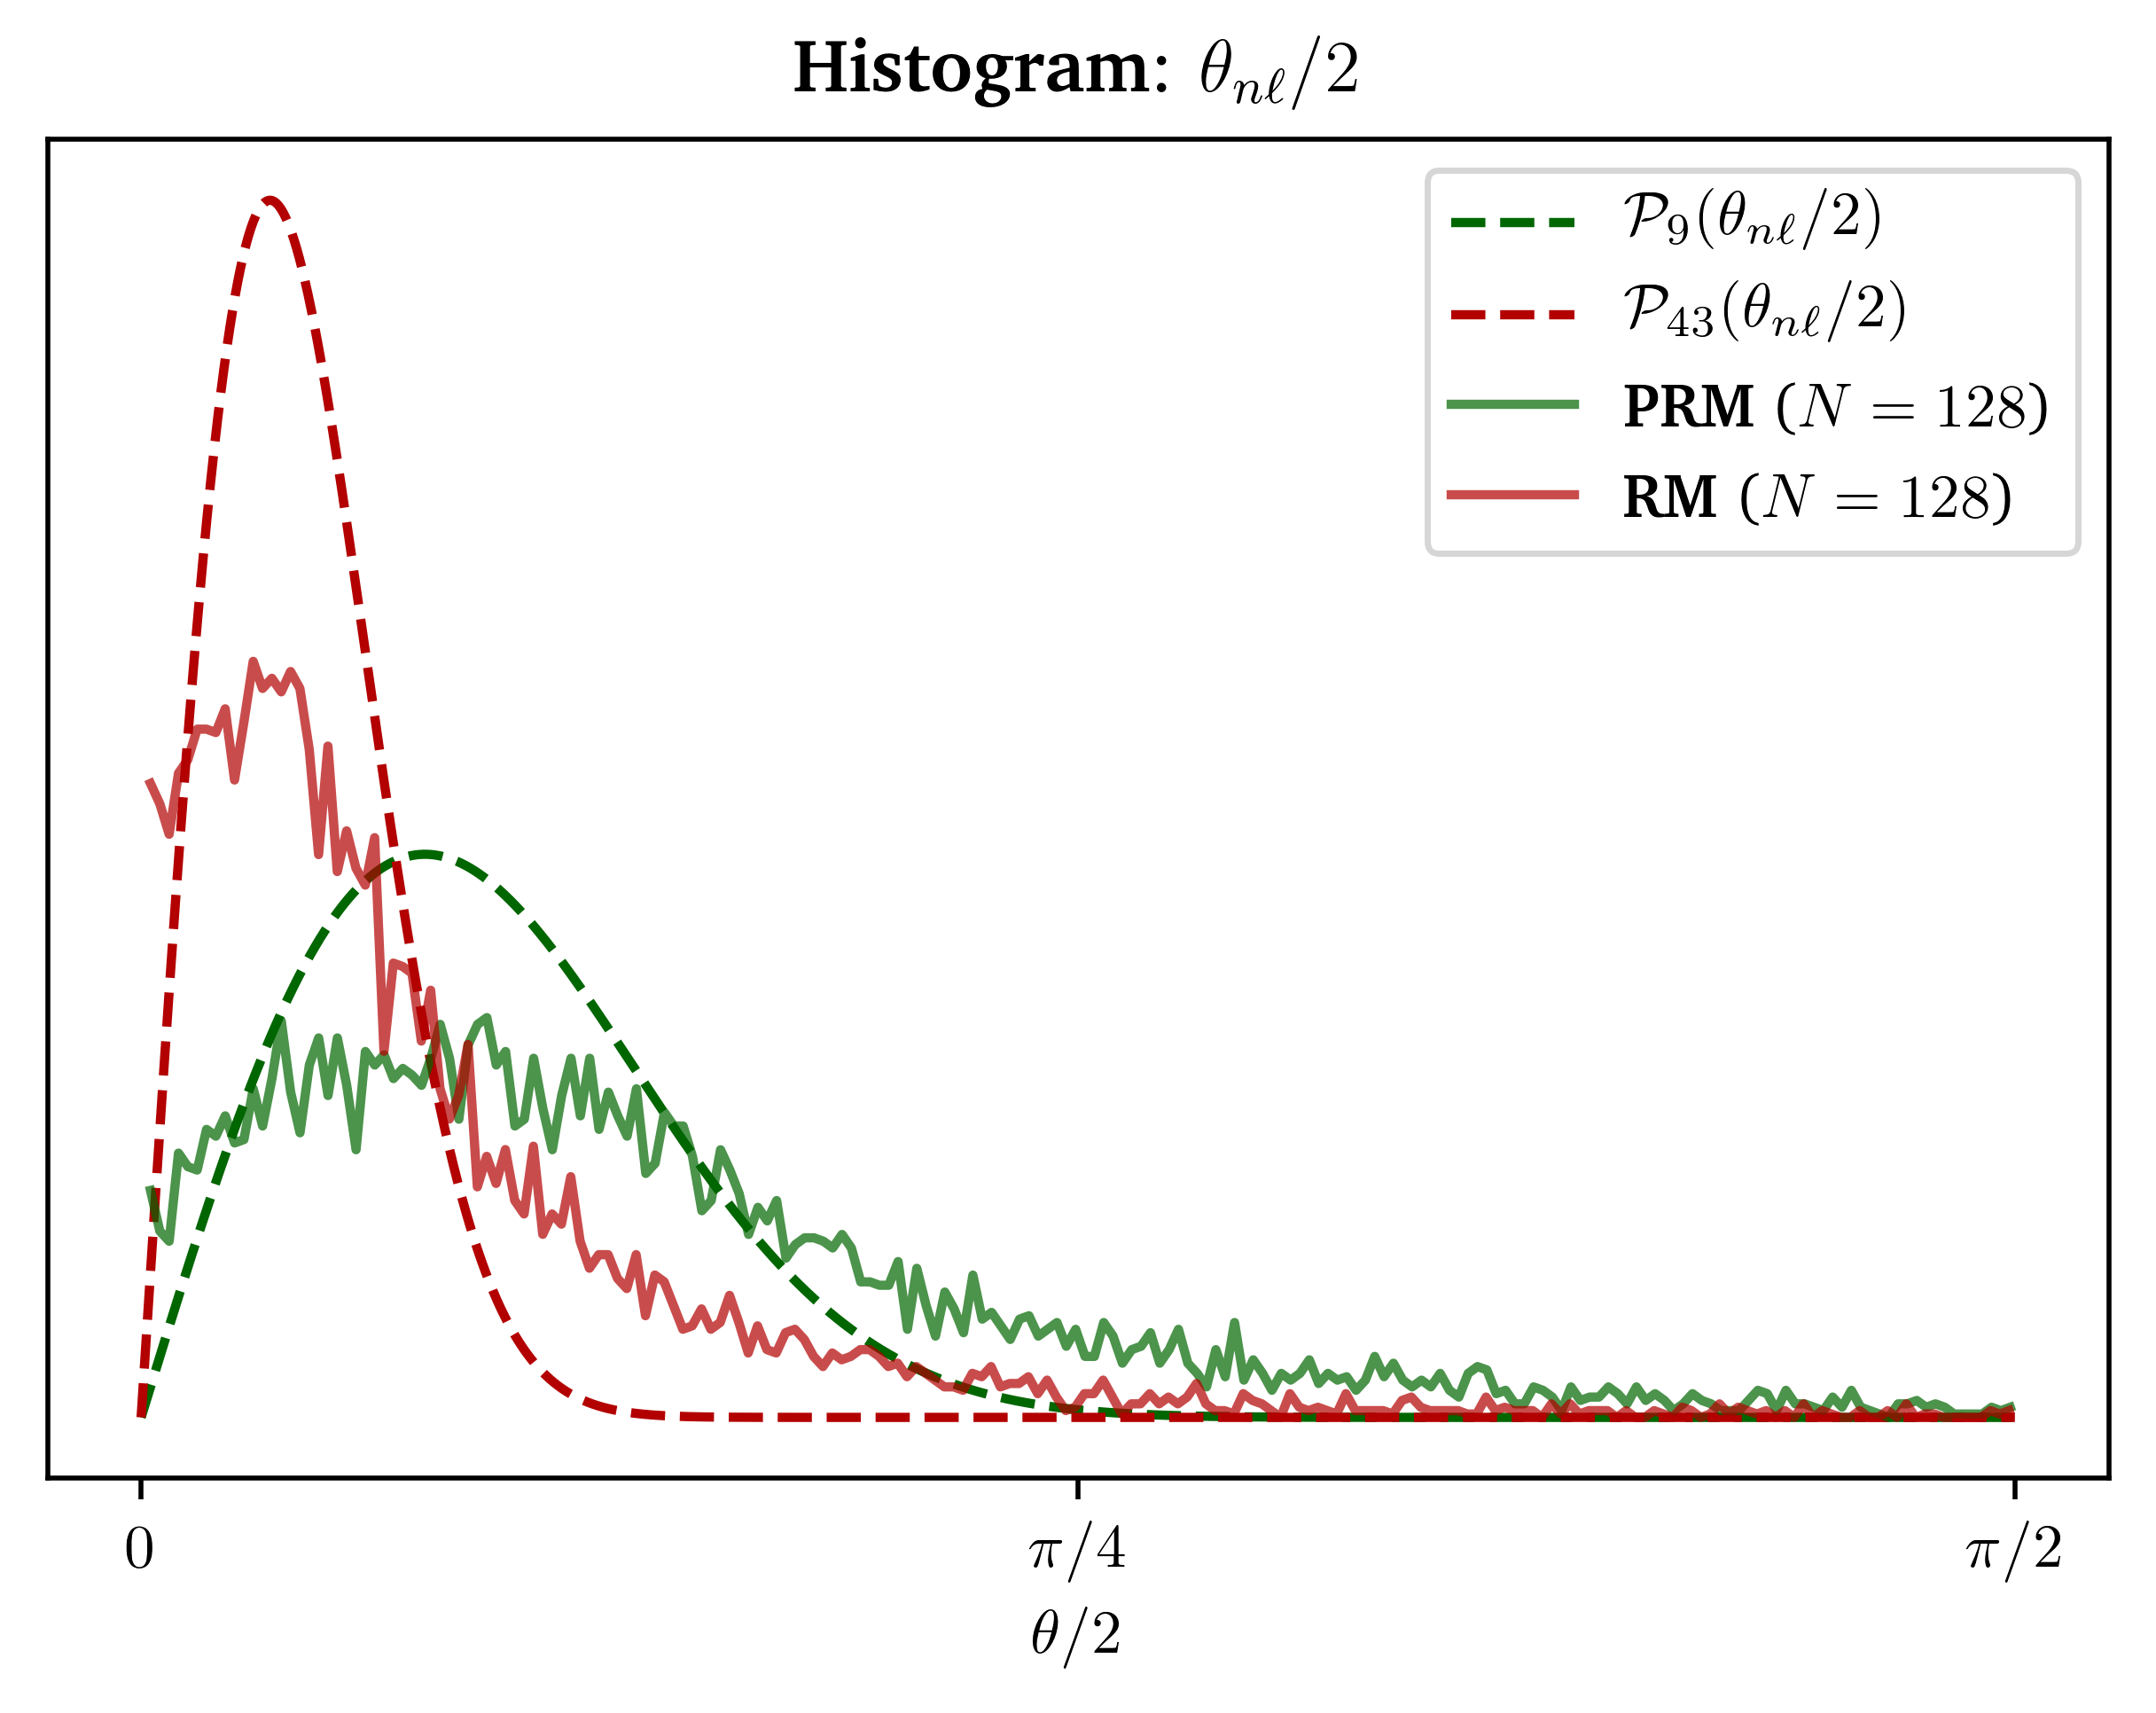

In [9]:
def get_theta_distribution(alpha: int=1, num_thetas: int=10000, override_uniform: bool=False):
    thetas = np.linspace(0, np.pi / 2, num_thetas)
    theta_vals = np.linspace(0, np.pi, num_thetas)
    if not override_uniform:
        theta_freqs = alpha * np.sin(thetas) * np.power(np.cos(thetas), 2 * alpha - 1)
    else:
        theta_freqs = np.pad(np.ones(int(num_thetas - 2)), ((1, 1),), 'constant') * 1 / np.pi
    return theta_vals, theta_freqs

prm_viz = MOResultsVisualizer('prm-default', rm_prm_results['results']['prm-default'],
                              title_fontsize=12, label_fontsize=10)
rm_viz = MOResultsVisualizer('rm-default', rm_prm_results['results']['rm-default'],
                             title_fontsize=12, label_fontsize=10)

plt.figure(dpi=500)
plt.plot(*(get_theta_distribution(9)), color=[0, 0.4, 0], linestyle='--')
plt.plot(*(get_theta_distribution(43)), color=[0.7, 0, 0], linestyle='--')
prm_viz.plot_thetas(plt.axes(), -1, color=[0, 0.4, 0], alpha=0.7)
rm_viz.plot_thetas(plt.axes(), -1, color=[0.7, 0, 0], alpha=0.7)
plt.legend([r'$\mathcal{P}_9(\theta_{n\ell} / 2)$',
            r'$\mathcal{P}_{43}(\theta_{n\ell} / 2)$',
            r'\textbf{PRM} ($N = 128$)', r'\textbf{RM} ($N = 128$)'])
plt.savefig('data/figures/13_rm_prm_distributions.pdf', bbox_inches='tight', pad_inches=0.02)